# KL divergence: non-Gaussian

In this example, we show how to test surrogate model covergence using the KL divergence metric for any general distribution.

In [ ]:
import alabi
import alabi.utility as ut
import alabi.metrics as metrics
import alabi.benchmarks as bm
import alabi.visualization as vis
from alabi.core import SurrogateModel
from alabi.metrics import kl_divergence_kde, compute_kl_single_trial_joblib, compute_kl_full_parallel

import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import os
from joblib import Parallel, delayed

## Run functions

First we'll define a run function for `alabi` that runs MCMC every `niter_per_batch` iterations

In [ ]:
def run_alabi(lnlike_fn, bounds, kernel="ExpSquaredKernel", savedir="results/",
              ntrain=50, nbatch=50, niter_per_batch=10):
    
    sm = SurrogateModel(lnlike_fn=lnlike_fn, bounds=bounds, ncore=ncore, savedir=savedir)
    sm.init_samples(ntrain=ntrain)
    sm.init_gp(kernel=kernel, fit_amp=True, fit_mean=True, white_noise=-12)
    
    # zeroth iteration
    sm.run_dynesty(like_fn=sm.surrogate_log_likelihood)
            
    for _ in range(nbatch):
        sm.active_train(niter=niter_per_batch, algorithm="bape", gp_opt_freq=10)
        try:
            sm.run_dynesty(like_fn=sm.surrogate_log_likelihood)
        except Exception as e:
            print(f"Error occurred while running dynesty: {e}")
            
    return sm

Next we'll define a wrapper around a function we want to test. In this example we'll use the eggbox function from Birky et al. 2025

In [ ]:
def run_single_trial(ntrain, kernel, trial, alabi_kwargs):
    """
    Run a single trial for all benchmark functions
    """
    base_dir = f"results_2d_init{ntrain}_mcmc/"
    
    sm = run_alabi(bm.eggbox["fn"], bounds=bm.eggbox["bounds"], kernel=kernel, ntrain=ntrain,
                savedir=f"{base_dir}/eggbox/{kernel}/{trial}", **alabi_kwargs)
    sm.savedir = f"{base_dir}/eggbox/{kernel}"
    sm.run_dynesty(like_fn=sm.true_log_likelihood)

## Configure a set of tests

In [ ]:
alabi_kwargs = {
    "nbatch": 25,           # total number of times we will compute KL divergence for a run
    "niter_per_batch": 10,  # how frequently (in number of iterations) to compute KL divergence
}

ntrials = 10        # how many trials per setting to average over
ncore = 8           # number of CPU cores to use 

# define which kernels we want to test
kernels = ["ExpSquaredKernel", "Matern52Kernel"]
# in this example we'll test two different kernels, but you can add more to the list

# define how many initial training samples to test
ntrain_list = [50]
# in this example we'll just test one setting, but you can add more to the list, e.g., ntrain_list = [20, 50, 100, 200]

# Create all task combinations
tasks = []
for ntrain in ntrain_list:
    for kernel in kernels:
        for trial in range(ntrials):
            tasks.append((ntrain, kernel, trial, alabi_kwargs))

print("Total number of configurations to run:", len(tasks))
print(f"Total number of iterations per run: {alabi_kwargs['nbatch'] * alabi_kwargs['niter_per_batch']}")
print(f"Total number of runs to compute average KL divergence: {ntrials}")
print(f"Total number of CPU cores available: {ncore}")

Total number of configurations to run: 20
Total number of iterations per run: 250
Total number of runs to compute average KL divergence: 10
Total number of CPU cores available: 8


These are all of the different configurations that we will try. For each configuration we will run `ntrials` and compute the average kl divergence as a function of iteration, sampled every `niter_per_batch` iterations, `nbatch` times

In [13]:
tasks

[(50, 'ExpSquaredKernel', 0, {'nbatch': 25, 'niter_per_batch': 10}),
 (50, 'ExpSquaredKernel', 1, {'nbatch': 25, 'niter_per_batch': 10}),
 (50, 'ExpSquaredKernel', 2, {'nbatch': 25, 'niter_per_batch': 10}),
 (50, 'ExpSquaredKernel', 3, {'nbatch': 25, 'niter_per_batch': 10}),
 (50, 'ExpSquaredKernel', 4, {'nbatch': 25, 'niter_per_batch': 10}),
 (50, 'ExpSquaredKernel', 5, {'nbatch': 25, 'niter_per_batch': 10}),
 (50, 'ExpSquaredKernel', 6, {'nbatch': 25, 'niter_per_batch': 10}),
 (50, 'ExpSquaredKernel', 7, {'nbatch': 25, 'niter_per_batch': 10}),
 (50, 'ExpSquaredKernel', 8, {'nbatch': 25, 'niter_per_batch': 10}),
 (50, 'ExpSquaredKernel', 9, {'nbatch': 25, 'niter_per_batch': 10}),
 (50, 'Matern52Kernel', 0, {'nbatch': 25, 'niter_per_batch': 10}),
 (50, 'Matern52Kernel', 1, {'nbatch': 25, 'niter_per_batch': 10}),
 (50, 'Matern52Kernel', 2, {'nbatch': 25, 'niter_per_batch': 10}),
 (50, 'Matern52Kernel', 3, {'nbatch': 25, 'niter_per_batch': 10}),
 (50, 'Matern52Kernel', 4, {'nbatch': 25, 

## Execute Trials

In [ ]:
results = Parallel(n_jobs=ncore)(
    delayed(run_single_trial)(ntrain, kernel, trial, alabi_kwargs)
    for ntrain, kernel, trial, alabi_kwargs in tasks
)

Computed 50 function evaluations: 10.0s 

Initialized GP with squared exponential kernel.
Successfully initialized GP on attempt 1


Computed 50 function evaluations: 10.0s 

Initialized GP with squared exponential kernel.
Successfully initialized GP on attempt 1








Optimized 5 hyperparameters: (0.217s)
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


Computed 50 function evaluations: 10.0s 

Initialized GP with squared exponential kernel.
Successfully initialized GP on attempt 1




Optimized 5 hyperparameters: (0.222s)
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


0it [00:00, ?it/s]5it/s, batch: 0 | bound: 0 | nc: 7 | ncall: 165 | eff(%): 35.472 | loglstar:   -inf < -28.894 <    inf | logz: -33.492 +/-  0.192 | dlogz: 1024.308 >  0.500]

Computed 50 function evaluations: 10.0s 

Initialized GP with squared exponential kernel.
Successfully initialized GP on attempt 1










Optimized 5 hyperparameters: (0.237s)
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


0it [00:00, ?it/s]29it/s, batch: 0 | bound: 0 | nc: 20 | ncall: 522 | eff(%): 31.833 | loglstar:   -inf < -1.222 <    inf | logz: -7.501 +/-  0.228 | dlogz: 1210.869 >  0.500]

Computed 50 function evaluations: 11.0s 

Computed 50 function evaluations: 11.0s 

Initialized GP with squared exponential kernel.
Successfully initialized GP on attempt 1


Initialized GP with squared exponential kernel.
Successfully initialized GP on attempt 1
Computed 50 function evaluations: 11.0s 

Initialized GP with squared exponential kernel.
Successfully initialized GP on attempt 1
Computed 50 function evaluations: 10.0s 

Initialized GP with squared exponential kernel.
Successfully initialized GP on attempt 1


287it [00:00, 485.34it/s, batch: 0 | bound: 0 | nc: 6 | ncall: 1539 | eff(%): 17.511 | loglstar:   -inf < 53.480 <    inf | logz: 46.931 +/-  0.238 | dlogz: 1155.341 >  0.500]]





Optimized 5 hyperparameters: (0.441s)
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


322it [00:00, 269.90it/s, batch: 0 | bound: 0 | nc: 18 | ncall: 2656 | eff(%): 11.684 | loglstar:   -inf < 284.061 <    inf | logz: 276.050 +/-  0.270 | dlogz: 940.457 >  0.500]

289it [00:01, 218.14it/s, batch: 0 | bound: 0 | nc: 38 | ncall: 1516 | eff(%): 17.884 | loglstar:   -inf < 99.553 <    inf | logz: 92.089 +/-  0.250 | dlogz: 2994.271 >  0.500] 









Optimized 5 hyperparameters: (0.859s)
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


319it [00:01, 198.21it/s, batch: 0 | bound: 0 | nc: 12 | ncall: 2140 | eff(%): 14.241 | loglstar:   -inf < 134.622 <    inf | logz: 127.393 +/-  0.255 | dlogz: 2958.408 >  0.500]











Optimized 5 hyperparameters: (1.288s)
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


95it [00:00, 938.39it/s, batch: 0 | bound: 0 | nc: 5 | ncall: 157 | eff(%): 36.965 | loglstar:   -inf < -46.738 <    inf | logz: -50.678 +/-  0.181 | dlogz: 248.829 >  0.500]500]





Optimized 5 hyperparameters: (1.352s)
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...




Optimized 5 hyperparameters: (1.466s)
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


11388it [00:20, 557.63it/s, batch: 32 | bound: 2 | nc: 1 | ncall: 22394 | eff(%): 50.817 | loglstar: 31.269 < 33.548 < 33.125 | logz: 26.884 +/-  0.070 | stop:  0.978] 1.336]641]     
  0%|          | 0/10 [00:00<?, ?it/s]| bound: 6 | nc: 1 | ncall: 23712 | eff(%): 43.003 | loglstar: 1631.268 < 1633.772 < 1633.885 | logz: 1615.144 +/-  0.139 | stop:  1.301]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/2/surrogate_model...
Running 10 active learning iterations using bape...


12665it [00:26, 476.01it/s, batch: 25 | bound: 6 | nc: 1 | ncall: 28557 | eff(%): 44.197 | loglstar: 1626.508 < 1634.290 < 1633.284 | logz: 1615.196 +/-  0.124 | stop:  0.972]141]
12086it [00:24, 472.54it/s, batch: 22 | bound: 6 | nc: 3 | ncall: 27612 | eff(%): 43.494 | loglstar: 49413.613 < 49419.872 < 49420.211 | logz: 49394.992 +/-  0.159 | stop:  1.185]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/1/surrogate_model...
Running 10 active learning iterations using bape...


11678it [00:25, 456.43it/s, batch: 27 | bound: 5 | nc: 1 | ncall: 28658 | eff(%): 40.639 | loglstar: 93.334 < 95.921 < 95.579 | logz: 86.204 +/-  0.084 | stop:  0.992]  1.081]
12546it [00:25, 492.40it/s, batch: 25 | bound: 6 | nc: 1 | ncall: 28430 | eff(%): 44.105 | loglstar: 396.646 < 404.634 < 403.535 | logz: 388.418 +/-  0.115 | stop:  0.977]021]


Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/5/surrogate_model...
Running 10 active learning iterations using bape...
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/4/surrogate_model...
Running 10 active learning iterations using bape...


12672it [00:27, 460.01it/s, batch: 24 | bound: 6 | nc: 1 | ncall: 28565 | eff(%): 44.348 | loglstar: 1468.101 < 1476.189 < 1475.038 | logz: 1458.124 +/-  0.126 | stop:  0.978]090]


Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/0/surrogate_model...
Running 10 active learning iterations using bape...


13024it [00:28, 460.15it/s, batch: 24 | bound: 6 | nc: 1 | ncall: 30454 | eff(%): 42.721 | loglstar: 3611.327 < 3614.362 < 3613.832 | logz: 3593.095 +/-  0.132 | stop:  0.984]046]
  0%|          | 0/10 [00:00<?, ?it/s]| bound: 0 | nc: 1 | ncall: 29095 | eff(%): 43.671 | loglstar: 49413.437 < 49415.461 < 49421.104 | logz: 49395.000 +/-  0.154 | stop:  1.081]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/7/surrogate_model...
Running 10 active learning iterations using bape...


13439it [00:28, 472.03it/s, batch: 25 | bound: 10 | nc: 1 | ncall: 31605 | eff(%): 42.469 | loglstar: 37500.320 < 37508.215 < 37507.913 | logz: 37484.224 +/-  0.144 | stop:  0.982]
13460it [00:28, 331.17it/s, batch: 25 | bound: 0 | nc: 1 | ncall: 30590 | eff(%): 44.001 | loglstar: 49413.393 < 49420.392 < 49420.234 | logz: 49395.002 +/-  0.146 | stop:  1.012] 

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/3/surrogate_model...
Running 10 active learning iterations using bape...


13937it [00:29, 473.37it/s, batch: 25 | bound: 6 | nc: 1 | ncall: 31490 | eff(%): 44.190 | loglstar: 49413.393 < 49421.410 < 49420.234 | logz: 49395.002 +/-  0.146 | stop:  0.972] 


Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/6/surrogate_model...
Running 10 active learning iterations using bape...


 70%|███████   | 7/10 [00:17<00:07,  2.55s/it]









Optimized 5 hyperparameters: (0.218s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/2/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


100%|██████████| 10/10 [00:24<00:00,  2.42s/it]
2154it [00:06, 406.08it/s, batch: 6 | bound: 4 | nc: 1 | ncall: 6402 | eff(%): 32.921 | loglstar: 23.575 < 26.777 < 27.012 | logz: 21.105 +/-  0.151 | stop:  8.182]           









Optimized 5 hyperparameters: (0.283s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/1/surrogate_model...


100%|██████████| 10/10 [00:24<00:00,  2.49s/it]| nc: 2 | ncall: 6522 | eff(%): 33.198 | loglstar: 23.575 < 26.992 < 27.012 | logz: 21.105 +/-  0.151 | stop:  8.182]
0it [00:00, ?it/s]

Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


212it [00:00, 343.98it/s, batch: 0 | bound: 0 | nc: 3 | ncall: 655 | eff(%): 28.079 | loglstar:   -inf <  0.132 <    inf | logz: -6.266 +/-  0.230 | dlogz: 1237.180 >  0.500]  











Optimized 5 hyperparameters: (0.307s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/0/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...




100%|██████████| 10/10 [00:25<00:00,  2.54s/it]| nc: 1 | ncall: 7184 | eff(%): 36.094 | loglstar: 23.004 < 24.547 < 26.863 | logz: 21.062 +/-  0.127 | stop:  5.247]
2661it [00:07, 477.38it/s, batch: 8 | bound: 1 | nc: 2 | ncall: 7306 | eff(%): 35.877 | loglstar: 23.004 < 25.240 < 26.863 | logz: 21.062 +/-  0.127 | stop:  5.247]>  0.500]





Optimized 5 hyperparameters: (0.237s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/5/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...




100%|██████████| 10/10 [00:25<00:00,  2.55s/it] nc: 7 | ncall: 358 | eff(%): 32.533 | loglstar:   -inf < -12.869 <    inf | logz: -17.387 +/-  0.190 | dlogz: 766.582 >  0.500]








Optimized 5 hyperparameters: (0.264s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/4/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


236it [00:00, 237.12it/s, batch: 0 | bound: 0 | nc: 15 | ncall: 1067 | eff(%): 20.223 | loglstar:   -inf < 74.235 <    inf | logz: 66.589 +/-  0.276 | dlogz: 880.047 >  0.500]]









Optimized 5 hyperparameters: (0.306s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/7/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


100%|██████████| 10/10 [00:24<00:00,  2.48s/it] nc: 22 | ncall: 1236 | eff(%): 21.033 | loglstar:   -inf <  6.438 <    inf | logz:  0.346 +/-  0.222 | dlogz: 81.993 >  0.500] 
323it [00:01, 143.84it/s, batch: 0 | bound: 0 | nc: 13 | ncall: 2163 | eff(%): 14.273 | loglstar:   -inf < 134.852 <    inf | logz: 127.965 +/-  0.255 | dlogz: 3051.085 >  0.500]









Optimized 5 hyperparameters: (0.262s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/3/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


100%|██████████| 10/10 [00:24<00:00,  2.48s/it]nc: 3 | ncall: 3400 | eff(%):  9.943 | loglstar:   -inf < 326.251 <    inf | logz: 318.121 +/-  0.269 | dlogz: 714.475 >  0.500]  
577it [00:03, 262.19it/s, batch: 0 | bound: 4 | nc: 6 | ncall: 4232 | eff(%): 13.319 | loglstar:   -inf < 622.584 <    inf | logz: 612.289 +/-  0.309 | dlogz: 821.796 >  0.500]]









Optimized 5 hyperparameters: (0.209s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/6/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


100%|██████████| 10/10 [00:23<00:00,  2.38s/it] nc: 1 | ncall: 3617 | eff(%): 12.295 | loglstar:   -inf < 522.964 <    inf | logz: 513.253 +/-  0.305 | dlogz: 519.817 >  0.500]0]
11399it [00:29, 390.28it/s, batch: 31 | bound: 4 | nc: 1 | ncall: 22596 | eff(%): 50.438 | loglstar: 20.833 < 27.267 < 26.822 | logz: 21.134 +/-  0.069 | stop:  0.995]op:  2.362]     
7356it [00:19, 401.55it/s, batch: 13 | bound: 4 | nc: 4 | ncall: 17663 | eff(%): 41.317 | loglstar: 48548.787 < 48553.797 < 48554.696 | logz: 48531.614 +/-  0.194 | stop:  2.193]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/2/surrogate_model...
Running 10 active learning iterations using bape...


12973it [00:35, 366.41it/s, batch: 24 | bound: 8 | nc: 1 | ncall: 29357 | eff(%): 44.145 | loglstar: 1084.905 < 1092.925 < 1092.548 | logz: 1075.619 +/-  0.123 | stop:  0.950]194] 
11785it [00:35, 333.32it/s, batch: 28 | bound: 6 | nc: 1 | ncall: 29094 | eff(%): 40.469 | loglstar: 79.647 < 86.836 < 86.066 | logz: 77.041 +/-  0.084 | stop:  0.995]:  1.077]
11703it [00:32, 314.36it/s, batch: 21 | bound: 6 | nc: 7 | ncall: 27380 | eff(%): 42.524 | loglstar: 34491.725 < 34494.279 < 34494.468 | logz: 34470.442 +/-  0.153 | stop:  1.194]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/0/surrogate_model...
Running 10 active learning iterations using bape...
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/5/surrogate_model...
Running 10 active learning iterations using bape...


12552it [00:36, 343.63it/s, batch: 24 | bound: 8 | nc: 1 | ncall: 29617 | eff(%): 42.288 | loglstar: 308.268 < 316.311 < 315.478 | logz: 301.232 +/-  0.110 | stop:  0.964]030] 25]
12890it [00:37, 614.13it/s, batch: 24 | bound: 6 | nc: 1 | ncall: 29717 | eff(%): 43.220 | loglstar: 1560.078 < 1567.564 < 1566.879 | logz: 1548.880 +/-  0.125 | stop:  1.030]125]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/4/surrogate_model...
Running 10 active learning iterations using bape...


12907it [00:38, 339.11it/s, batch: 24 | bound: 6 | nc: 1 | ncall: 29734 | eff(%): 43.277 | loglstar: 1560.078 < 1567.908 < 1566.879 | logz: 1548.880 +/-  0.125 | stop:  0.986]058]
12943it [00:36, 416.44it/s, batch: 24 | bound: 4 | nc: 6 | ncall: 29013 | eff(%): 44.409 | loglstar: 3336.598 < 3342.901 < 3343.826 | logz: 3324.051 +/-  0.131 | stop:  1.022]075]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/1/surrogate_model...
Running 10 active learning iterations using bape...


13201it [00:37, 355.36it/s, batch: 24 | bound: 7 | nc: 1 | ncall: 29430 | eff(%): 44.807 | loglstar: 3336.598 < 3344.594 < 3343.826 | logz: 3324.051 +/-  0.131 | stop:  0.973]058]
12659it [00:35, 378.55it/s, batch: 23 | bound: 5 | nc: 1 | ncall: 29313 | eff(%): 42.979 | loglstar: 34486.970 < 34493.120 < 34493.758 | logz: 34470.416 +/-  0.145 | stop:  1.075]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/7/surrogate_model...
Running 10 active learning iterations using bape...


13208it [00:37, 354.31it/s, batch: 25 | bound: 4 | nc: 1 | ncall: 29886 | eff(%): 44.159 | loglstar: 48552.415 < 48555.617 < 48554.567 | logz: 48531.505 +/-  0.140 | stop:  0.967]
13176it [00:37, 309.92it/s, batch: 24 | bound: 6 | nc: 9 | ncall: 30424 | eff(%): 43.108 | loglstar: 34486.842 < 34493.451 < 34493.731 | logz: 34470.395 +/-  0.143 | stop:  1.026]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/6/surrogate_model...
Running 10 active learning iterations using bape...


13320it [00:38, 349.93it/s, batch: 24 | bound: 6 | nc: 1 | ncall: 30622 | eff(%): 43.440 | loglstar: 34486.842 < 34494.790 < 34493.731 | logz: 34470.395 +/-  0.143 | stop:  0.985]
  0%|          | 0/10 [00:00<?, ?it/s].52s/it]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/3/surrogate_model...
Running 10 active learning iterations using bape...


 20%|██        | 2/10 [00:05<00:19,  2.49s/it]









Optimized 5 hyperparameters: (0.307s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/2/surrogate_model...


 40%|████      | 4/10 [00:10<00:15,  2.56s/it] nc: 1 | ncall: 39 | eff(%): 23.022 | loglstar:   -inf < -81.231 <    inf | logz: -86.114 +/-  0.196 | dlogz: 109.094 >  0.500]

Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


5824it [00:14, 431.34it/s, batch: 16 | bound: 3 | nc: 2 | ncall: 13004 | eff(%): 44.333 | loglstar: 20.898 < 25.397 < 26.069 | logz: 20.167 +/-  0.089 | stop:  2.088]        









Optimized 5 hyperparameters: (0.293s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/0/surrogate_model...


100%|██████████| 10/10 [00:25<00:00,  2.50s/it] | nc: 3 | ncall: 13118 | eff(%): 44.487 | loglstar: 20.898 < 25.935 < 26.069 | logz: 20.167 +/-  0.089 | stop:  2.088]
35it [00:00, 349.84it/s, batch: 0 | bound: 0 | nc: 2 | ncall: 49 | eff(%): 23.490 | loglstar:   -inf < -61.294 <    inf | logz: -66.315 +/-  0.204 | dlogz: 742.771 >  0.500]

Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...






100%|██████████| 10/10 [00:25<00:00,  2.52s/it]nc: 2 | ncall: 174 | eff(%): 35.036 | loglstar:   -inf < -25.567 <    inf | logz: -29.508 +/-  0.176 | dlogz: 902.720 >  0.500]
6090it [00:15, 450.96it/s, batch: 17 | bound: 1 | nc: 5 | ncall: 13401 | eff(%): 45.074 | loglstar: 20.765 < 23.447 < 26.059 | logz: 20.183 +/-  0.086 | stop:  1.949]>  0.500]





Optimized 5 hyperparameters: (0.24s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/5/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...




100%|██████████| 10/10 [00:24<00:00,  2.41s/it] nc: 7 | ncall: 314 | eff(%): 33.816 | loglstar:   -inf < -15.758 <    inf | logz: -19.750 +/-  0.178 | dlogz: 101.689 >  0.500]
0it [00:00, ?it/s]







Optimized 5 hyperparameters: (0.269s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/4/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


6456it [00:16, 408.66it/s, batch: 18 | bound: 1 | nc: 2 | ncall: 14013 | eff(%): 45.535 | loglstar: 24.683 < 25.459 < 26.053 | logz: 20.180 +/-  0.084 | stop:  1.825]  0.500] ]

100%|██████████| 10/10 [00:24<00:00,  2.46s/it] | nc: 1 | ncall: 14104 | eff(%): 45.560 | loglstar: 24.683 < 25.772 < 26.053 | logz: 20.180 +/-  0.084 | stop:  1.825]9 >  0.500]
6557it [00:16, 387.14it/s, batch: 18 | bound: 3 | nc: 2 | ncall: 14211 | eff(%): 45.611 | loglstar: 24.683 < 26.038 < 26.053 | logz: 20.180 +/-  0.084 | stop:  1.825] >  0.500]





Optimized 5 hyperparameters: (0.378s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/1/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...






100%|██████████| 10/10 [00:24<00:00,  2.40s/it]nc: 3 | ncall: 123 | eff(%): 36.323 | loglstar:   -inf < -67.499 <    inf | logz: -73.303 +/-  0.223 | dlogz: 1243.625 >  0.500] ]
37it [00:00, 368.94it/s, batch: 0 | bound: 0 | nc: 2 | ncall: 45 | eff(%): 25.517 | loglstar:   -inf < -107.826 <    inf | logz: -113.392 +/-  0.228 | dlogz: 618.459 >  0.500]]





Optimized 5 hyperparameters: (0.395s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/7/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


436it [00:02, 146.74it/s, batch: 0 | bound: 1 | nc: 4 | ncall: 3865 | eff(%): 10.996 | loglstar:   -inf < 117.481 <    inf | logz: 109.251 +/-  0.272 | dlogz: 125.547 >  0.500]0]









Optimized 5 hyperparameters: (0.281s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/6/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


100%|██████████| 10/10 [00:23<00:00,  2.38s/it] nc: 3 | ncall: 3923 | eff(%): 11.434 | loglstar:   -inf < 134.028 <    inf | logz: 125.901 +/-  0.275 | dlogz: 108.519 >  0.500]] 
7572it [00:19, 365.87it/s, batch: 21 | bound: 3 | nc: 4 | ncall: 15957 | eff(%): 47.066 | loglstar: 20.406 < 25.266 < 26.030 | logz: 20.154 +/-  0.080 | stop:  1.552]>  0.500] ]









Optimized 5 hyperparameters: (0.301s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/3/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


100%|██████████| 10/10 [00:24<00:00,  2.41s/it]
11331it [00:29, 389.20it/s, batch: 31 | bound: 4 | nc: 1 | ncall: 22566 | eff(%): 50.175 | loglstar: 19.892 < 26.438 < 26.007 | logz: 20.134 +/-  0.068 | stop:  0.991]4.549]31]       
4740it [00:14, 321.22it/s, batch: 12 | bound: 2 | nc: 2 | ncall: 13060 | eff(%): 35.917 | loglstar: 80.996 < 83.689 < 86.297 | logz: 77.368 +/-  0.126 | stop:  2.824]p: 17.931]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/2/surrogate_model...
Running 10 active learning iterations using bape...


11816it [00:35, 335.24it/s, batch: 28 | bound: 6 | nc: 1 | ncall: 28442 | eff(%): 41.530 | loglstar: 79.629 < 87.018 < 86.204 | logz: 77.389 +/-  0.084 | stop:  0.975]top:  1.228] 
12209it [00:34, 349.33it/s, batch: 25 | bound: 6 | nc: 1 | ncall: 28373 | eff(%): 43.000 | loglstar: 292.843 < 300.541 < 299.610 | logz: 285.589 +/-  0.110 | stop:  0.999]134]305]
11276it [00:32, 342.18it/s, batch: 20 | bound: 1 | nc: 2 | ncall: 25904 | eff(%): 43.338 | loglstar: 47618.767 < 47621.167 < 47625.413 | logz: 47602.035 +/-  0.153 | stop:  1.228]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/5/surrogate_model...
Running 10 active learning iterations using bape...
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/4/surrogate_model...
Running 10 active learning iterations using bape...


12529it [00:36, 304.39it/s, batch: 24 | bound: 5 | nc: 6 | ncall: 28672 | eff(%): 43.277 | loglstar: 1507.308 < 1512.656 < 1514.222 | logz: 1496.184 +/-  0.124 | stop:  1.026]168]

100%|██████████| 10/10 [00:23<00:00,  2.36s/it]2 | nc: 3 | ncall: 28690 | eff(%): 42.078 | loglstar: 3111.154 < 3114.415 < 3117.908 | logz: 3098.935 +/-  0.130 | stop:  1.071]234]
12170it [00:36, 291.60it/s, batch: 24 | bound: 3 | nc: 5 | ncall: 28784 | eff(%): 42.066 | loglstar: 3111.154 < 3115.099 < 3117.908 | logz: 3098.935 +/-  0.130 | stop:  1.071]234]





Optimized 5 hyperparameters: (0.358s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/2/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


12636it [00:38, 330.03it/s, batch: 25 | bound: 6 | nc: 1 | ncall: 29916 | eff(%): 42.121 | loglstar: 1001.644 < 1004.593 < 1004.028 | logz: 988.286 +/-  0.115 | stop:  0.970]]234]
12827it [00:36, 347.68it/s, batch: 24 | bound: 7 | nc: 1 | ncall: 29177 | eff(%): 43.695 | loglstar: 1507.308 < 1515.207 < 1514.222 | logz: 1496.184 +/-  0.124 | stop:  0.980]168]


Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/0/surrogate_model...
Running 10 active learning iterations using bape...
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/1/surrogate_model...
Running 10 active learning iterations using bape...


13019it [00:38, 336.46it/s, batch: 25 | bound: 6 | nc: 1 | ncall: 30497 | eff(%): 42.632 | loglstar: 3111.092 < 3118.846 < 3117.908 | logz: 3098.919 +/-  0.128 | stop:  0.981]105]
12031it [00:36, 298.20it/s, batch: 22 | bound: 3 | nc: 3 | ncall: 28119 | eff(%): 42.551 | loglstar: 32569.202 < 32570.789 < 32571.294 | logz: 32548.775 +/-  0.146 | stop:  1.105]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/7/surrogate_model...
Running 10 active learning iterations using bape...


12955it [00:39, 330.06it/s, batch: 24 | bound: 5 | nc: 1 | ncall: 29869 | eff(%): 43.329 | loglstar: 32568.848 < 32572.352 < 32571.735 | logz: 32548.779 +/-  0.142 | stop:  0.976] 
2009it [00:05, 463.56it/s, batch: 6 | bound: 2 | nc: 1 | ncall: 5621 | eff(%): 34.885 | loglstar: 22.247 < 24.625 < 25.651 | logz: 19.984 +/-  0.147 | stop:  8.299]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/3/surrogate_model...
Running 10 active learning iterations using bape...


13810it [00:40, 343.31it/s, batch: 24 | bound: 8 | nc: 1 | ncall: 30884 | eff(%): 44.623 | loglstar: 47618.542 < 47626.474 < 47625.826 | logz: 47602.090 +/-  0.141 | stop:  0.961]


Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/6/surrogate_model...
Running 10 active learning iterations using bape...


8368it [00:21, 356.93it/s, batch: 24 | bound: 1 | nc: 2 | ncall: 16720 | eff(%): 49.632 | loglstar: 19.770 < 22.213 < 25.421 | logz: 19.941 +/-  0.072 | stop:  1.358]

100%|██████████| 10/10 [00:24<00:00,  2.42s/it] | nc: 1 | ncall: 16797 | eff(%): 49.666 | loglstar: 19.770 < 23.353 < 25.421 | logz: 19.941 +/-  0.072 | stop:  1.358]
32it [00:00, 315.71it/s, batch: 0 | bound: 0 | nc: 2 | ncall: 41 | eff(%): 22.695 | loglstar:   -inf < -74.484 <    inf | logz: -79.553 +/-  0.214 | dlogz: 120.130 >  0.500]





Optimized 5 hyperparameters: (0.31s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/5/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


221it [00:00, 344.72it/s, batch: 0 | bound: 0 | nc: 6 | ncall: 672 | eff(%): 28.627 | loglstar:   -inf < -0.085 <    inf | logz: -5.935 +/-  0.221 | dlogz: 88.080 >  0.500]  









Optimized 5 hyperparameters: (0.313s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/4/surrogate_model...


100%|██████████| 10/10 [00:24<00:00,  2.49s/it]
8692it [00:22, 302.83it/s, batch: 25 | bound: 0 | nc: 1 | ncall: 17272 | eff(%): 50.324 | loglstar: 19.687 < 23.848 < 25.420 | logz: 19.922 +/-  0.071 | stop:  1.298]

Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


 90%|█████████ | 9/10 [00:21<00:02,  2.41s/it]| nc: 1 | ncall: 2432 | eff(%): 12.283 | loglstar:   -inf < 63.159 <    inf | logz: 56.553 +/-  0.236 | dlogz: 206.302 >  0.500]  









Optimized 5 hyperparameters: (0.331s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/0/surrogate_model...


100%|██████████| 10/10 [00:24<00:00,  2.41s/it]
9339it [00:24, 263.52it/s, batch: 27 | bound: 0 | nc: 1 | ncall: 18378 | eff(%): 50.816 | loglstar: 19.561 < 22.450 < 25.416 | logz: 19.904 +/-  0.070 | stop:  1.199] 0.500]]

Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


 80%|████████  | 8/10 [00:19<00:04,  2.45s/it]| nc: 1 | ncall: 3720 | eff(%): 12.827 | loglstar:   -inf < 162.600 <    inf | logz: 154.078 +/-  0.285 | dlogz: 108.793 >  0.500]









Optimized 5 hyperparameters: (0.365s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/1/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.


100%|██████████| 10/10 [00:25<00:00,  2.52s/it] | nc: 1 | ncall: 19012 | eff(%): 51.057 | loglstar: 19.542 < 22.645 < 25.708 | logz: 19.909 +/-  0.069 | stop:  1.154]6 >  0.500]
9776it [00:25, 347.97it/s, batch: 28 | bound: 1 | nc: 7 | ncall: 19124 | eff(%): 50.827 | loglstar: 19.542 < 22.628 < 25.708 | logz: 19.909 +/-  0.069 | stop:  1.154] >  0.500]

Running dynesty with 100 live points on 1 cores...


341it [00:02, 70.51it/s, batch: 0 | bound: 1 | nc: 7 | ncall: 3301 | eff(%): 10.026 | loglstar:   -inf < 309.878 <    inf | logz: 302.355 +/-  0.270 | dlogz: 493.211 >  0.500]  

1034it [00:04, 352.31it/s, batch: 0 | bound: 13 | nc: 4 | ncall: 5082 | eff(%): 19.954 | loglstar:   -inf < 277.669 <    inf | logz: 265.507 +/-  0.335 | dlogz: 16.195 >  0.500]





Optimized 5 hyperparameters: (0.384s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/7/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


100%|██████████| 10/10 [00:24<00:00,  2.46s/it]
1244it [00:05, 316.58it/s, batch: 0 | bound: 14 | nc: 1 | ncall: 5279 | eff(%): 23.127 | loglstar:   -inf < 935.810 <    inf | logz: 921.617 +/-  0.362 | dlogz: 16.279 >  0.500] 









Optimized 5 hyperparameters: (0.312s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/6/surrogate_model...
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/2/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


11185it [00:29, 373.63it/s, batch: 31 | bound: 4 | nc: 1 | ncall: 21633 | eff(%): 51.656 | loglstar: 19.408 < 25.843 < 25.398 | logz: 19.939 +/-  0.065 | stop:  1.000] >  0.500]
  0%|          | 0/10 [00:00<?, ?it/s]

Running 10 active learning iterations using bape...


170it [00:00, 389.95it/s, batch: 0 | bound: 0 | nc: 5 | ncall: 402 | eff(%): 33.865 | loglstar:   -inf <  7.088 <    inf | logz:  1.124 +/-  0.223 | dlogz: 38525.841 >  0.500]  









Optimized 5 hyperparameters: (0.327s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/3/surrogate_model...


100%|██████████| 10/10 [00:24<00:00,  2.48s/it] nc: 4 | ncall: 3856 | eff(%): 11.021 | loglstar:   -inf < 489.510 <    inf | logz: 479.887 +/-  0.308 | dlogz: 2011.526 >  0.500]
1525it [00:05, 353.49it/s, batch: 0 | bound: 18 | nc: 1 | ncall: 5973 | eff(%): 25.111 | loglstar:   -inf < 947.355 <    inf | logz: 931.945 +/-  0.377 | dlogz:  3.295 >  0.500]

Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


7274it [00:21, 343.38it/s, batch: 13 | bound: 4 | nc: 16 | ncall: 18058 | eff(%): 39.993 | loglstar: 31008.134 < 31012.763 < 31014.108 | logz: 30991.192 +/-  0.194 | stop:  2.189]    

100%|██████████| 10/10 [00:22<00:00,  2.28s/it] | nc: 1 | ncall: 21916 | eff(%): 40.469 | loglstar: 1461.476 < 1466.893 < 1468.267 | logz: 1449.443 +/-  0.150 | stop:  1.560]189] 
9967it [00:30, 357.63it/s, batch: 19 | bound: 5 | nc: 3 | ncall: 24400 | eff(%): 40.607 | loglstar: 284.857 < 291.011 < 291.529 | logz: 277.467 +/-  0.121 | stop:  1.296]  2.189]





Optimized 5 hyperparameters: (0.368s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/2/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


11927it [00:38, 311.90it/s, batch: 27 | bound: 5 | nc: 1 | ncall: 29063 | eff(%): 41.023 | loglstar: 80.076 < 87.313 < 86.522 | logz: 77.530 +/-  0.083 | stop:  0.981]  1.221]45] 
10784it [00:32, 322.69it/s, batch: 21 | bound: 2 | nc: 2 | ncall: 25215 | eff(%): 42.554 | loglstar: 2920.589 < 2924.226 < 2927.841 | logz: 2908.330 +/-  0.138 | stop:  1.221]45]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/5/surrogate_model...
Running 10 active learning iterations using bape...


12639it [00:39, 322.73it/s, batch: 24 | bound: 8 | nc: 1 | ncall: 30052 | eff(%): 41.975 | loglstar: 284.592 < 292.596 < 291.872 | logz: 277.542 +/-  0.109 | stop:  0.965]112]357]
11338it [00:34, 307.12it/s, batch: 22 | bound: 2 | nc: 5 | ncall: 26337 | eff(%): 42.759 | loglstar: 2920.565 < 2922.462 < 2927.290 | logz: 2908.362 +/-  0.134 | stop:  1.149]357]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/4/surrogate_model...
Running 10 active learning iterations using bape...


12443it [00:39, 318.65it/s, batch: 25 | bound: 4 | nc: 1 | ncall: 28261 | eff(%): 43.939 | loglstar: 947.521 < 950.534 < 949.558 | logz: 933.751 +/-  0.116 | stop:  0.991]  1.285] 
11855it [00:36, 291.62it/s, batch: 23 | bound: 2 | nc: 1 | ncall: 27566 | eff(%): 42.813 | loglstar: 2920.496 < 2923.828 < 2927.679 | logz: 2908.349 +/-  0.132 | stop:  1.098]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/0/surrogate_model...
Running 10 active learning iterations using bape...


13172it [00:40, 327.89it/s, batch: 25 | bound: 7 | nc: 1 | ncall: 30620 | eff(%): 42.992 | loglstar: 1460.914 < 1468.705 < 1467.706 | logz: 1449.499 +/-  0.123 | stop:  0.956]196]
11473it [00:36, 322.41it/s, batch: 21 | bound: 3 | nc: 5 | ncall: 27400 | eff(%): 41.632 | loglstar: 46708.337 < 46712.588 < 46715.014 | logz: 46691.531 +/-  0.154 | stop:  1.196]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/1/surrogate_model...
Running 10 active learning iterations using bape...


12826it [00:39, 325.77it/s, batch: 24 | bound: 6 | nc: 1 | ncall: 29428 | eff(%): 43.553 | loglstar: 2920.372 < 2928.208 < 2927.303 | logz: 2908.347 +/-  0.130 | stop:  0.995]157]
11764it [00:36, 260.15it/s, batch: 22 | bound: 3 | nc: 1 | ncall: 27438 | eff(%): 42.563 | loglstar: 31007.297 < 31010.553 < 31014.026 | logz: 30991.202 +/-  0.149 | stop:  1.157]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/7/surrogate_model...
Running 10 active learning iterations using bape...


13333it [00:41, 323.61it/s, batch: 24 | bound: 6 | nc: 1 | ncall: 30604 | eff(%): 43.529 | loglstar: 31007.177 < 31015.038 < 31014.015 | logz: 30991.191 +/-  0.141 | stop:  0.990]
6990it [00:19, 394.96it/s, batch: 19 | bound: 4 | nc: 1 | ncall: 15079 | eff(%): 45.978 | loglstar: 19.517 < 24.776 < 24.881 | logz: 19.371 +/-  0.080 | stop:  1.730]stop:  1.036]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/3/surrogate_model...
Running 10 active learning iterations using bape...


13173it [00:42, 312.12it/s, batch: 24 | bound: 6 | nc: 1 | ncall: 30816 | eff(%): 42.722 | loglstar: 46708.145 < 46716.079 < 46714.974 | logz: 46691.532 +/-  0.145 | stop:  0.995]
  0%|          | 0/10 [00:00<?, ?it/s] bound: 0 | nc: 1 | ncall: 15248 | eff(%): 46.695 | loglstar: 19.333 < 22.742 < 24.875 | logz: 19.377 +/-  0.078 | stop:  1.632]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/6/surrogate_model...
Running 10 active learning iterations using bape...


11102it [00:32, 320.59it/s, batch: 31 | bound: 3 | nc: 10 | ncall: 22039 | eff(%): 50.088 | loglstar: 18.810 < 23.845 < 24.857 | logz: 19.357 +/-  0.065 | stop:  1.026]

100%|██████████| 10/10 [00:24<00:00,  2.47s/it]3 | nc: 5 | ncall: 22142 | eff(%): 50.067 | loglstar: 18.810 < 24.343 < 24.857 | logz: 19.357 +/-  0.065 | stop:  1.026] 
11189it [00:32, 324.88it/s, batch: 31 | bound: 4 | nc: 7 | ncall: 22222 | eff(%): 50.067 | loglstar: 18.810 < 24.696 < 24.857 | logz: 19.357 +/-  0.065 | stop:  1.026]  0.500]





Optimized 5 hyperparameters: (0.421s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/5/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


11313it [00:32, 345.23it/s, batch: 31 | bound: 4 | nc: 1 | ncall: 22383 | eff(%): 50.484 | loglstar: 18.810 < 25.295 < 24.857 | logz: 19.357 +/-  0.065 | stop:  0.993] 0.500] 
  0%|          | 0/10 [00:00<?, ?it/s]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/2/surrogate_model...
Running 10 active learning iterations using bape...


288it [00:01, 145.95it/s, batch: 0 | bound: 0 | nc: 6 | ncall: 1442 | eff(%): 18.677 | loglstar:   -inf < 12.012 <    inf | logz:  6.150 +/-  0.223 | dlogz: 72.887 >  0.500] 

305it [00:01, 100.76it/s, batch: 0 | bound: 0 | nc: 57 | ncall: 1864 | eff(%): 15.530 | loglstar:   -inf < 14.266 <    inf | logz:  8.379 +/-  0.214 | dlogz: 71.072 >  0.500]





Optimized 5 hyperparameters: (0.421s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/4/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


100%|██████████| 10/10 [00:24<00:00,  2.49s/it]
356it [00:02, 51.64it/s, batch: 0 | bound: 0 | nc: 45 | ncall: 3282 | eff(%): 10.526 | loglstar:   -inf < 24.501 <    inf | logz: 17.938 +/-  0.236 | dlogz: 64.788 >  0.500]]  









Optimized 5 hyperparameters: (0.32s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/0/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


100%|██████████| 10/10 [00:24<00:00,  2.43s/it]
922it [00:05, 359.38it/s, batch: 0 | bound: 10 | nc: 2 | ncall: 5033 | eff(%): 17.962 | loglstar:   -inf < 86.102 <    inf | logz: 77.009 +/-  0.282 | dlogz:  1.532 >  0.500]0] 

100%|██████████| 10/10 [00:24<00:00,  2.41s/it]| nc: 1 | ncall: 5097 | eff(%): 18.472 | loglstar:   -inf < 86.376 <    inf | logz: 77.293 +/-  0.282 | dlogz:  1.148 >  0.500]00]
32it [00:00, 319.68it/s, batch: 0 | bound: 0 | nc: 1 | ncall: 39 | eff(%): 23.022 | loglstar:   -inf < -100.738 <    inf | logz: -106.348 +/-  0.235 | dlogz: 1161.036 >  0.500] 





Optimized 5 hyperparameters: (0.338s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/1/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


 80%|████████  | 8/10 [00:18<00:04,  2.29s/it]| nc: 1 | ncall: 4740 | eff(%): 15.455 | loglstar:   -inf < 209.671 <    inf | logz: 198.585 +/-  0.314 | dlogz: 66.255 >  0.500]]

100%|██████████| 10/10 [00:24<00:00,  2.45s/it] nc: 9 | ncall: 3955 | eff(%): 12.084 | loglstar:   -inf < 462.178 <    inf | logz: 452.673 +/-  0.288 | dlogz: 344.310 >  0.500]
26it [00:00, 257.90it/s, batch: 0 | bound: 0 | nc: 1 | ncall: 32 | eff(%): 19.697 | loglstar:   -inf < -104.815 <    inf | logz: -110.345 +/-  0.232 | dlogz: 2484.194 >  0.500]]





Optimized 5 hyperparameters: (0.433s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/7/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


2166it [00:08, 333.53it/s, batch: 1 | bound: 7 | nc: 4 | ncall: 8008 | eff(%): 26.593 | loglstar: 286.752 < 287.018 <    inf | logz: 271.416 +/-  0.597 | stop: 24.927]] >  0.500]0]

100%|██████████| 10/10 [00:23<00:00,  2.38s/it] | nc: 7 | ncall: 5379 | eff(%): 20.131 | loglstar:   -inf < 1331.857 <    inf | logz: 1317.622 +/-  0.367 | dlogz: 88.174 >  0.500] 
2008it [00:07, 354.53it/s, batch: 1 | bound: 3 | nc: 3 | ncall: 7249 | eff(%): 27.150 | loglstar: 909.406 < 909.241 <    inf | logz: 892.817 +/-  0.607 | stop: 23.828]65 >  0.500]





Optimized 5 hyperparameters: (0.357s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/3/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


1004it [00:04, 337.54it/s, batch: 0 | bound: 12 | nc: 1 | ncall: 4963 | eff(%): 19.830 | loglstar:   -inf < 2594.840 <    inf | logz: 2580.002 +/-  0.371 | dlogz: 124.726 >  0.500]

100%|██████████| 10/10 [00:23<00:00,  2.38s/it] | nc: 7 | ncall: 5143 | eff(%): 20.961 | loglstar:   -inf < 2650.872 <    inf | logz: 2636.778 +/-  0.365 | dlogz: 86.542 >  0.500] 






Optimized 5 hyperparameters: (0.397s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/6/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


5262it [00:16, 303.32it/s, batch: 9 | bound: 3 | nc: 1 | ncall: 13948 | eff(%): 37.346 | loglstar: 2758.025 < 2760.782 < 2763.489 | logz: 2744.261 +/-  0.210 | stop:  3.232]]02]      

100%|██████████| 10/10 [00:22<00:00,  2.26s/it]| nc: 6 | ncall: 11102 | eff(%): 35.492 | loglstar: 29700.012 < 29701.501 < 29703.963 | logz: 29680.464 +/-  0.324 | stop:  7.013]
4036it [00:12, 418.41it/s, batch: 6 | bound: 2 | nc: 2 | ncall: 11196 | eff(%): 35.613 | loglstar: 29700.012 < 29702.290 < 29703.963 | logz: 29680.464 +/-  0.324 | stop:  7.013]





Optimized 5 hyperparameters: (0.424s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/2/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


11722it [00:38, 308.03it/s, batch: 27 | bound: 6 | nc: 1 | ncall: 28457 | eff(%): 41.130 | loglstar: 80.274 < 87.557 < 86.860 | logz: 77.912 +/-  0.088 | stop:  0.996]041] 1.569] 
  0%|          | 0/10 [00:00<?, ?it/s] bound: 5 | nc: 1 | ncall: 22142 | eff(%): 41.110 | loglstar: 29697.502 < 29703.522 < 29703.905 | logz: 29680.579 +/-  0.175 | stop:  1.627]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/5/surrogate_model...
Running 10 active learning iterations using bape...


12403it [00:37, 327.78it/s, batch: 25 | bound: 10 | nc: 1 | ncall: 28645 | eff(%): 43.209 | loglstar: 279.115 < 287.126 < 286.765 | logz: 271.393 +/-  0.114 | stop:  0.980]1.522]
11210it [00:34, 232.81it/s, batch: 22 | bound: 0 | nc: 1 | ncall: 25694 | eff(%): 43.629 | loglstar: 1419.227 < 1421.931 < 1425.899 | logz: 1407.493 +/-  0.132 | stop:  1.149]50]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/4/surrogate_model...
Running 10 active learning iterations using bape...


12436it [00:40, 304.18it/s, batch: 25 | bound: 3 | nc: 1 | ncall: 28762 | eff(%): 43.184 | loglstar: 906.547 < 909.630 < 908.479 | logz: 892.694 +/-  0.116 | stop:  0.988]  1.261] 
7527it [00:20, 342.44it/s, batch: 21 | bound: 2 | nc: 2 | ncall: 15216 | eff(%): 49.093 | loglstar: 18.804 < 23.048 < 24.345 | logz: 19.044 +/-  0.076 | stop:  1.567]:  1.033]261]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/0/surrogate_model...
Running 10 active learning iterations using bape...


12841it [00:39, 321.33it/s, batch: 24 | bound: 7 | nc: 1 | ncall: 28874 | eff(%): 44.360 | loglstar: 1419.018 < 1426.885 < 1425.890 | logz: 1407.479 +/-  0.126 | stop:  0.988]192]
  0%|          | 0/10 [00:00<?, ?it/s] bound: 4 | nc: 3 | ncall: 16108 | eff(%): 49.347 | loglstar: 18.728 < 24.288 < 24.343 | logz: 19.060 +/-  0.074 | stop:  1.500]stop:  1.229]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/1/surrogate_model...
Running 10 active learning iterations using bape...


13282it [00:41, 323.04it/s, batch: 24 | bound: 8 | nc: 1 | ncall: 30442 | eff(%): 43.593 | loglstar: 2756.351 < 2764.403 < 2763.812 | logz: 2744.299 +/-  0.128 | stop:  0.953]147] 
8708it [00:24, 363.70it/s, batch: 24 | bound: 3 | nc: 4 | ncall: 17288 | eff(%): 50.069 | loglstar: 18.621 < 23.859 < 24.336 | logz: 19.069 +/-  0.072 | stop:  1.363]stop:  1.139]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/7/surrogate_model...
Running 10 active learning iterations using bape...


13520it [00:41, 329.47it/s, batch: 24 | bound: 7 | nc: 1 | ncall: 30852 | eff(%): 43.743 | loglstar: 29696.946 < 29704.883 < 29703.865 | logz: 29680.584 +/-  0.140 | stop:  0.974] 
13221it [00:40, 429.28it/s, batch: 25 | bound: 6 | nc: 6 | ncall: 29284 | eff(%): 44.914 | loglstar: 45848.955 < 45852.484 < 45852.644 | logz: 45826.639 +/-  0.161 | stop:  1.003]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/3/surrogate_model...
Running 10 active learning iterations using bape...


13406it [00:41, 323.71it/s, batch: 25 | bound: 8 | nc: 1 | ncall: 29562 | eff(%): 45.269 | loglstar: 45848.955 < 45852.918 < 45852.644 | logz: 45826.639 +/-  0.161 | stop:  0.947]
10419it [00:29, 259.69it/s, batch: 29 | bound: 0 | nc: 1 | ncall: 20190 | eff(%): 51.605 | loglstar: 18.400 < 22.840 < 24.320 | logz: 19.082 +/-  0.066 | stop:  1.103]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/6/surrogate_model...
Running 10 active learning iterations using bape...


11741it [00:33, 348.94it/s, batch: 32 | bound: 4 | nc: 1 | ncall: 22525 | eff(%): 52.113 | loglstar: 22.777 < 24.760 < 24.603 | logz: 19.108 +/-  0.063 | stop:  0.966]
 40%|████      | 4/10 [00:09<00:14,  2.38s/it]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/2/surrogate_model...
Running 10 active learning iterations using bape...


 60%|██████    | 6/10 [00:14<00:09,  2.40s/it]

100%|██████████| 10/10 [00:24<00:00,  2.43s/it]
0it [00:00, ?it/s]





Optimized 5 hyperparameters: (0.445s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/5/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


240it [00:01, 193.26it/s, batch: 0 | bound: 0 | nc: 12 | ncall: 1020 | eff(%): 21.429 | loglstar:   -inf <  1.627 <    inf | logz: -3.704 +/-  0.207 | dlogz: 82.380 >  0.500]









Optimized 5 hyperparameters: (0.422s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/4/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


100%|██████████| 10/10 [00:23<00:00,  2.38s/it]
878it [00:05, 285.68it/s, batch: 0 | bound: 11 | nc: 7 | ncall: 5020 | eff(%): 17.148 | loglstar:   -inf < 85.411 <    inf | logz: 76.387 +/-  0.280 | dlogz:  2.711 >  0.500]] 

100%|██████████| 10/10 [00:24<00:00,  2.41s/it] nc: 6 | ncall: 4488 | eff(%): 15.323 | loglstar:   -inf < 213.277 <    inf | logz: 202.627 +/-  0.313 | dlogz: 67.524 >  0.500]
0it [00:00, ?it/s]





Optimized 5 hyperparameters: (0.362s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/0/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


1243it [00:05, 346.96it/s, batch: 0 | bound: 15 | nc: 3 | ncall: 5686 | eff(%): 21.483 | loglstar:   -inf < 277.912 <    inf | logz: 264.725 +/-  0.346 | dlogz:  5.251 >  0.500]

100%|██████████| 10/10 [00:24<00:00,  2.45s/it]nc: 56 | ncall: 2109 | eff(%): 13.671 | loglstar:   -inf < 149.589 <    inf | logz: 142.447 +/-  0.250 | dlogz: 600.088 >  0.500] 
1320it [00:06, 327.18it/s, batch: 0 | bound: 16 | nc: 2 | ncall: 5871 | eff(%): 22.107 | loglstar:   -inf < 279.206 <    inf | logz: 265.960 +/-  0.348 | dlogz:  3.474 >  0.500]





Optimized 5 hyperparameters: (0.384s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/1/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


1685it [00:07, 272.71it/s, batch: 1 | bound: 0 | nc: 3 | ncall: 6620 | eff(%): 25.453 | loglstar: 282.728 < 282.136 <    inf | logz: 267.977 +/-  0.583 | stop: 23.033]           

100%|██████████| 10/10 [00:24<00:00,  2.40s/it] nc: 2 | ncall: 3878 | eff(%): 12.469 | loglstar:   -inf < 442.688 <    inf | logz: 433.527 +/-  0.300 | dlogz: 375.947 >  0.500] 
34it [00:00, 338.26it/s, batch: 0 | bound: 0 | nc: 3 | ncall: 46 | eff(%): 23.288 | loglstar:   -inf < -71.897 <    inf | logz: -77.398 +/-  0.225 | dlogz: 771.435 >  0.500]00]





Optimized 5 hyperparameters: (0.552s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/7/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


1962it [00:07, 416.32it/s, batch: 1 | bound: 1 | nc: 7 | ncall: 6969 | eff(%): 27.614 | loglstar: 875.557 < 875.079 <    inf | logz: 858.659 +/-  0.613 | stop: 23.058]9 >  0.500]]

100%|██████████| 10/10 [00:24<00:00,  2.43s/it]| nc: 6 | ncall: 4399 | eff(%): 21.938 | loglstar:   -inf < 2396.209 <    inf | logz: 2382.312 +/-  0.359 | dlogz: 184.408 >  0.500]]
3433it [00:12, 386.86it/s, batch: 7 | bound: 1 | nc: 3 | ncall: 10421 | eff(%): 32.494 | loglstar: 277.497 < 278.534 < 282.125 | logz: 268.052 +/-  0.220 | stop:  5.367] >  0.500]]





Optimized 5 hyperparameters: (0.378s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/3/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


2281it [00:09, 215.17it/s, batch: 1 | bound: 7 | nc: 6 | ncall: 7755 | eff(%): 28.906 | loglstar: 875.557 < 875.713 <    inf | logz: 858.659 +/-  0.613 | stop: 23.058]7] >  0.500] 

100%|██████████| 10/10 [00:24<00:00,  2.48s/it] | nc: 1 | ncall: 7034 | eff(%): 26.521 | loglstar:   -inf < 1385.157 <    inf | logz: 1366.468 +/-  0.416 | dlogz:  1.963 >  0.500]
1515it [00:05, 369.53it/s, batch: 0 | bound: 18 | nc: 1 | ncall: 5591 | eff(%): 26.621 | loglstar:   -inf < 2606.214 <    inf | logz: 2589.239 +/-  0.400 | dlogz: 16.329 >  0.500]





Optimized 5 hyperparameters: (0.499s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/6/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


2846it [00:10, 335.53it/s, batch: 2 | bound: 1 | nc: 4 | ncall: 8456 | eff(%): 33.074 | loglstar: 2618.660 < 2619.228 < 2620.033 | logz: 2601.211 +/-  0.407 | stop: 17.044]]>  0.500] 

100%|██████████| 10/10 [00:24<00:00,  2.49s/it] | nc: 3 | ncall: 5719 | eff(%): 23.372 | loglstar:   -inf < 28277.389 <    inf | logz: 28259.829 +/-  0.412 | dlogz: 240.332 >  0.500]]
1087it [00:04, 377.44it/s, batch: 0 | bound: 11 | nc: 4 | ncall: 5021 | eff(%): 21.226 | loglstar:   -inf < 43280.657 <    inf | logz: 43264.543 +/-  0.400 | dlogz: 1559.522 >  0.500]





Optimized 5 hyperparameters: (0.475s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/2/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


11694it [00:40, 291.24it/s, batch: 27 | bound: 6 | nc: 1 | ncall: 28077 | eff(%): 41.567 | loglstar: 85.194 < 87.838 < 87.499 | logz: 78.136 +/-  0.085 | stop:  0.994]op:  1.934]     
7080it [00:20, 240.67it/s, batch: 20 | bound: 0 | nc: 1 | ncall: 15153 | eff(%): 46.723 | loglstar: 18.306 < 23.354 < 23.818 | logz: 18.018 +/-  0.080 | stop:  1.631]top:  1.908]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/5/surrogate_model...
Running 10 active learning iterations using bape...


12700it [00:41, 302.84it/s, batch: 24 | bound: 11 | nc: 1 | ncall: 29832 | eff(%): 42.473 | loglstar: 275.021 < 283.064 < 282.769 | logz: 268.091 +/-  0.111 | stop:  0.974]1.637] 
8146it [00:23, 357.80it/s, batch: 23 | bound: 2 | nc: 2 | ncall: 16896 | eff(%): 47.800 | loglstar: 22.296 < 23.756 < 23.827 | logz: 18.033 +/-  0.076 | stop:  1.426]:  1.242]32]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/4/surrogate_model...
Running 10 active learning iterations using bape...


12623it [00:41, 302.94it/s, batch: 24 | bound: 6 | nc: 1 | ncall: 29858 | eff(%): 42.178 | loglstar: 867.891 < 875.790 < 874.825 | logz: 858.822 +/-  0.119 | stop:  0.993]  1.437]
12963it [00:39, 324.17it/s, batch: 24 | bound: 7 | nc: 1 | ncall: 28504 | eff(%): 45.443 | loglstar: 1380.502 < 1388.581 < 1387.967 | logz: 1368.442 +/-  0.141 | stop:  0.985].414]


Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/0/surrogate_model...
Running 10 active learning iterations using bape...
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/1/surrogate_model...


 20%|██        | 2/10 [00:04<00:17,  2.18s/it]0 | nc: 1 | ncall: 19217 | eff(%): 49.742 | loglstar: 21.875 < 22.160 < 23.807 | logz: 18.021 +/-  0.070 | stop:  1.159]:  1.077] 

Running 10 active learning iterations using bape...


13044it [00:41, 311.47it/s, batch: 25 | bound: 6 | nc: 1 | ncall: 29178 | eff(%): 44.641 | loglstar: 2613.130 < 2621.122 < 2620.030 | logz: 2601.422 +/-  0.127 | stop:  0.972]247] 
11178it [00:37, 274.64it/s, batch: 21 | bound: 3 | nc: 2 | ncall: 26248 | eff(%): 42.274 | loglstar: 28570.992 < 28575.033 < 28577.665 | logz: 28554.345 +/-  0.155 | stop:  1.247]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/7/surrogate_model...
Running 10 active learning iterations using bape...


11214it [00:33, 335.82it/s, batch: 32 | bound: 4 | nc: 1 | ncall: 21994 | eff(%): 50.919 | loglstar: 17.823 < 24.231 < 23.804 | logz: 18.016 +/-  0.067 | stop:  0.977]top:  1.184]
11700it [00:39, 307.92it/s, batch: 22 | bound: 3 | nc: 2 | ncall: 27423 | eff(%): 42.393 | loglstar: 28570.898 < 28575.333 < 28577.650 | logz: 28554.332 +/-  0.152 | stop:  1.184]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/2/surrogate_model...
Running 10 active learning iterations using bape...


13509it [00:43, 311.07it/s, batch: 24 | bound: 9 | nc: 1 | ncall: 31161 | eff(%): 43.333 | loglstar: 45038.541 < 45046.565 < 45046.261 | logz: 45020.977 +/-  0.149 | stop:  0.974] 
13331it [00:44, 298.16it/s, batch: 25 | bound: 5 | nc: 2 | ncall: 30894 | eff(%): 42.940 | loglstar: 28570.659 < 28577.161 < 28578.077 | logz: 28554.335 +/-  0.145 | stop:  1.029]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/6/surrogate_model...
Running 10 active learning iterations using bape...


13587it [00:45, 295.87it/s, batch: 25 | bound: 8 | nc: 1 | ncall: 31408 | eff(%): 43.188 | loglstar: 28570.659 < 28578.758 < 28578.077 | logz: 28554.335 +/-  0.145 | stop:  0.980]
  0%|          | 0/10 [00:00<?, ?it/s].40s/it]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/3/surrogate_model...
Running 10 active learning iterations using bape...


 20%|██        | 2/10 [00:04<00:18,  2.29s/it]









Optimized 5 hyperparameters: (0.546s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/5/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


 60%|██████    | 6/10 [00:14<00:09,  2.43s/it] nc: 5 | ncall: 3107 | eff(%): 10.196 | loglstar:   -inf < 19.642 <    inf | logz: 13.304 +/-  0.224 | dlogz: 71.272 >  0.500]  

343it [00:03, 51.34it/s, batch: 0 | bound: 1 | nc: 12 | ncall: 3402 | eff(%):  9.794 | loglstar:   -inf < 22.631 <    inf | logz: 16.432 +/-  0.230 | dlogz: 67.937 >  0.500]





Optimized 5 hyperparameters: (0.589s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/4/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


100%|██████████| 10/10 [00:24<00:00,  2.47s/it]
359it [00:03, 33.57it/s, batch: 0 | bound: 1 | nc: 2 | ncall: 3503 | eff(%):  9.964 | loglstar:   -inf < 67.142 <    inf | logz: 60.676 +/-  0.232 | dlogz: 180.850 >  0.500]  

100%|██████████| 10/10 [00:24<00:00,  2.43s/it] nc: 4 | ncall: 3697 | eff(%): 10.956 | loglstar:   -inf < 94.797 <    inf | logz: 86.493 +/-  0.267 | dlogz: 158.002 >  0.500]
1487it [00:07, 270.79it/s, batch: 1 | bound: 6 | nc: 1 | ncall: 6031 | eff(%): 24.155 | loglstar: 87.772 < 87.970 <    inf | logz: 78.289 +/-  0.473 | stop: 27.727]





Optimized 5 hyperparameters: (0.475s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/0/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


1616it [00:07, 269.17it/s, batch: 1 | bound: 8 | nc: 2 | ncall: 6349 | eff(%): 24.961 | loglstar: 87.772 < 88.017 <    inf | logz: 78.289 +/-  0.473 | stop: 27.727]8 >  0.500]]

100%|██████████| 10/10 [00:24<00:00,  2.48s/it] nc: 1 | ncall: 449 | eff(%): 30.601 | loglstar:   -inf < -14.475 <    inf | logz: -19.141 +/-  0.194 | dlogz: 625.580 >  0.500]]
198it [00:00, 272.91it/s, batch: 0 | bound: 0 | nc: 2 | ncall: 597 | eff(%): 28.407 | loglstar:   -inf <  0.924 <    inf | logz: -4.825 +/-  0.224 | dlogz: 611.235 >  0.500]  ]





Optimized 5 hyperparameters: (0.524s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/1/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


2536it [00:10, 317.82it/s, batch: 6 | bound: 2 | nc: 7 | ncall: 8255 | eff(%): 30.144 | loglstar: 84.029 < 86.165 < 87.059 | logz: 78.249 +/-  0.191 | stop:  7.705]84 >  0.500]]

100%|██████████| 10/10 [00:24<00:00,  2.43s/it] | nc: 2 | ncall: 6382 | eff(%): 22.077 | loglstar:   -inf < 276.976 <    inf | logz: 262.696 +/-  0.361 | dlogz:  2.743 >  0.500]
17it [00:00, 169.30it/s, batch: 0 | bound: 0 | nc: 1 | ncall: 18 | eff(%): 14.407 | loglstar:   -inf < -171.974 <    inf | logz: -177.195 +/-  0.214 | dlogz: 1699.904 >  0.500]]





Optimized 5 hyperparameters: (0.52s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/7/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


622it [00:04, 278.87it/s, batch: 0 | bound: 6 | nc: 2 | ncall: 4261 | eff(%): 14.263 | loglstar:   -inf < 522.084 <    inf | logz: 510.939 +/-  0.322 | dlogz: 647.635 >  0.500]]

100%|██████████| 10/10 [00:24<00:00,  2.41s/it]| nc: 2 | ncall: 7451 | eff(%): 25.460 | loglstar: 279.716 < 279.659 <    inf | logz: 264.231 +/-  0.593 | stop: 22.585]>  0.500]]]






Optimized 5 hyperparameters: (0.533s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/2/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


2601it [00:10, 306.12it/s, batch: 2 | bound: 3 | nc: 5 | ncall: 8659 | eff(%): 29.347 | loglstar: 843.997 < 845.178 < 845.442 | logz: 829.955 +/-  0.371 | stop: 18.105]1]>  0.500] 

100%|██████████| 10/10 [00:23<00:00,  2.34s/it]| nc: 2 | ncall: 7838 | eff(%): 28.303 | loglstar: 1352.881 < 1352.699 <    inf | logz: 1333.422 +/-  0.670 | stop: 24.181]>  0.500]
2306it [00:09, 389.55it/s, batch: 1 | bound: 2 | nc: 1 | ncall: 7930 | eff(%): 28.575 | loglstar: 1352.881 < 1352.827 <    inf | logz: 1333.422 +/-  0.670 | stop: 24.181]>  0.500]





Optimized 5 hyperparameters: (0.501s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/6/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


1364it [00:05, 418.49it/s, batch: 1 | bound: 8 | nc: 1 | ncall: 5428 | eff(%): 24.612 | loglstar: 22.361 < 23.716 <    inf | logz: 17.443 +/-  0.378 | stop: 31.142]5.672 >  0.500] 

100%|██████████| 10/10 [00:23<00:00,  2.35s/it]| nc: 2 | ncall: 5542 | eff(%): 26.019 | loglstar: 21.819 < 21.926 < 22.367 | logz: 17.435 +/-  0.194 | stop: 15.759]3.374 >  0.500]]
0it [00:00, ?it/s].67it/s, batch: 1 | bound: 8 | nc: 6 | ncall: 8706 | eff(%): 30.228 | loglstar: 1352.881 < 1353.220 <    inf | logz: 1333.422 +/-  0.670 | stop: 24.181]





Optimized 5 hyperparameters: (0.516s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/3/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


12188it [00:44, 276.37it/s, batch: 28 | bound: 6 | nc: 1 | ncall: 29003 | eff(%): 41.887 | loglstar: 80.766 < 87.969 < 87.309 | logz: 78.242 +/-  0.083 | stop:  0.967]  1.348]24]     
10167it [00:31, 298.39it/s, batch: 29 | bound: 3 | nc: 1 | ncall: 20827 | eff(%): 48.518 | loglstar: 21.634 < 23.308 < 23.635 | logz: 17.573 +/-  0.069 | stop:  1.135]  1.261]24]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/5/surrogate_model...
Running 10 active learning iterations using bape...


12189it [00:41, 290.37it/s, batch: 23 | bound: 7 | nc: 1 | ncall: 28133 | eff(%): 43.222 | loglstar: 272.002 < 279.934 < 278.909 | logz: 264.256 +/-  0.113 | stop:  0.995]270]67]
10435it [00:34, 250.69it/s, batch: 21 | bound: 2 | nc: 1 | ncall: 24407 | eff(%): 42.450 | loglstar: 2486.788 < 2488.833 < 2493.340 | logz: 2474.364 +/-  0.139 | stop:  1.270]67]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/4/surrogate_model...
Running 10 active learning iterations using bape...


12544it [00:41, 305.66it/s, batch: 25 | bound: 6 | nc: 1 | ncall: 29025 | eff(%): 43.144 | loglstar: 838.691 < 846.709 < 845.601 | logz: 829.935 +/-  0.116 | stop:  0.975]206]44] 
11436it [00:35, 319.13it/s, batch: 32 | bound: 3 | nc: 1 | ncall: 23059 | eff(%): 49.526 | loglstar: 21.591 < 23.712 < 23.256 | logz: 17.566 +/-  0.065 | stop:  0.984]op:  1.614]


Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/0/surrogate_model...
Running 10 active learning iterations using bape...
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/2/surrogate_model...


9344it [00:31, 274.90it/s, batch: 18 | bound: 6 | nc: 2 | ncall: 22527 | eff(%): 41.203 | loglstar: 44289.127 < 44294.837 < 44295.938 | logz: 44271.617 +/-  0.174 | stop:  1.614]

Running 10 active learning iterations using bape...


12810it [00:44, 290.46it/s, batch: 25 | bound: 7 | nc: 1 | ncall: 29143 | eff(%): 43.865 | loglstar: 1345.391 < 1353.173 < 1352.174 | logz: 1333.430 +/-  0.130 | stop:  0.993]392]
12389it [00:41, 328.91it/s, batch: 24 | bound: 8 | nc: 2 | ncall: 28560 | eff(%): 43.173 | loglstar: 2486.517 < 2493.829 < 2494.020 | logz: 2474.337 +/-  0.132 | stop:  1.090]403]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/1/surrogate_model...
Running 10 active learning iterations using bape...


13070it [00:43, 301.88it/s, batch: 25 | bound: 7 | nc: 1 | ncall: 29852 | eff(%): 43.724 | loglstar: 2486.451 < 2494.333 < 2493.330 | logz: 2474.333 +/-  0.127 | stop:  0.979]320] 
 10%|█         | 1/10 [00:02<00:20,  2.29s/it] 6 | nc: 2 | ncall: 25808 | eff(%): 42.204 | loglstar: 44288.820 < 44295.168 < 44295.355 | logz: 44271.612 +/-  0.160 | stop:  1.320]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/7/surrogate_model...
Running 10 active learning iterations using bape...


13445it [00:45, 295.65it/s, batch: 26 | bound: 3 | nc: 1 | ncall: 30702 | eff(%): 43.688 | loglstar: 44293.335 < 44296.468 < 44295.344 | logz: 44271.616 +/-  0.141 | stop:  0.977] 
13125it [00:44, 204.43it/s, batch: 25 | bound: 0 | nc: 1 | ncall: 29744 | eff(%): 44.127 | loglstar: 27587.295 < 27589.319 < 27594.121 | logz: 27571.066 +/-  0.139 | stop:  1.004]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/6/surrogate_model...
Running 10 active learning iterations using bape...


13628it [00:46, 296.01it/s, batch: 25 | bound: 7 | nc: 1 | ncall: 30746 | eff(%): 44.222 | loglstar: 27587.295 < 27595.004 < 27594.121 | logz: 27571.066 +/-  0.139 | stop:  0.961] 
  0%|          | 0/10 [00:00<?, ?it/s].34s/it]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/3/surrogate_model...
Running 10 active learning iterations using bape...


 20%|██        | 2/10 [00:04<00:20,  2.50s/it]









Optimized 5 hyperparameters: (0.511s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/5/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


 70%|███████   | 7/10 [00:17<00:07,  2.43s/it]| nc: 1 | ncall: 454 | eff(%): 33.394 | loglstar:   -inf < -10.082 <    inf | logz: -14.284 +/-  0.185 | dlogz: 74.730 >  0.500]

100%|██████████| 10/10 [00:24<00:00,  2.44s/it] nc: 5 | ncall: 987 | eff(%): 23.551 | loglstar:   -inf <  1.438 <    inf | logz: -4.217 +/-  0.216 | dlogz: 64.055 >  0.500]  
14it [00:00, 138.46it/s, batch: 0 | bound: 0 | nc: 1 | ncall: 14 | eff(%): 12.281 | loglstar:   -inf < -84.893 <    inf | logz: -89.873 +/-  0.207 | dlogz: 187.706 >  0.500]





Optimized 5 hyperparameters: (0.69s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/4/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


409it [00:03, 66.32it/s, batch: 0 | bound: 2 | nc: 15 | ncall: 3954 | eff(%): 10.089 | loglstar:   -inf < 30.337 <    inf | logz: 22.999 +/-  0.246 | dlogz: 55.573 >  0.500]] 

340it [00:02, 52.03it/s, batch: 0 | bound: 0 | nc: 15 | ncall: 2818 | eff(%): 11.652 | loglstar:   -inf < 56.175 <    inf | logz: 50.397 +/-  0.224 | dlogz: 173.496 >  0.500]









Optimized 5 hyperparameters: (0.717s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/2/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


100%|██████████| 10/10 [00:24<00:00,  2.46s/it]nc: 30 | ncall: 3088 | eff(%): 11.041 | loglstar:   -inf < 59.888 <    inf | logz: 53.391 +/-  0.240 | dlogz: 170.483 >  0.500]
0it [00:00, ?it/s]





Optimized 5 hyperparameters: (0.703s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/0/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


1495it [00:07, 214.78it/s, batch: 1 | bound: 6 | nc: 4 | ncall: 6469 | eff(%): 22.607 | loglstar: 87.949 < 88.137 <    inf | logz: 78.187 +/-  0.475 | stop: 26.953]265 >  0.500]

100%|██████████| 10/10 [00:24<00:00,  2.48s/it]| nc: 2 | ncall: 6740 | eff(%): 23.431 | loglstar: 87.949 < 88.189 <    inf | logz: 78.187 +/-  0.475 | stop: 26.953]15 >  0.500]]
1325it [00:07, 317.33it/s, batch: 0 | bound: 17 | nc: 2 | ncall: 6229 | eff(%): 20.935 | loglstar:   -inf < 273.658 <    inf | logz: 260.153 +/-  0.351 | dlogz:  3.929 >  0.500]





Optimized 5 hyperparameters: (0.579s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/1/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


1085it [00:05, 276.43it/s, batch: 0 | bound: 13 | nc: 1 | ncall: 5289 | eff(%): 20.134 | loglstar:   -inf < 796.688 <    inf | logz: 783.481 +/-  0.351 | dlogz: 25.587 >  0.500]

100%|██████████| 10/10 [00:24<00:00,  2.47s/it] | nc: 4 | ncall: 5403 | eff(%): 20.534 | loglstar:   -inf < 802.701 <    inf | logz: 788.965 +/-  0.353 | dlogz: 19.651 >  0.500]
6it [00:00, 59.33it/s, batch: 0 | bound: 0 | nc: 1 | ncall: 6 | eff(%):  5.660 | loglstar:   -inf < -185.628 <    inf | logz: -190.291 +/-  0.207 | dlogz: 2197.802 >  0.500]500]





Optimized 5 hyperparameters: (0.502s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/7/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


4505it [00:16, 320.05it/s, batch: 8 | bound: 6 | nc: 3 | ncall: 12558 | eff(%): 35.579 | loglstar: 271.527 < 276.783 < 277.066 | logz: 262.471 +/-  0.193 | stop:  3.864]]>  0.500] 

100%|██████████| 10/10 [00:24<00:00,  2.41s/it] | nc: 10 | ncall: 6778 | eff(%): 24.629 | loglstar:   -inf < 2376.511 <    inf | logz: 2358.697 +/-  0.407 | dlogz:  5.519 >  0.500]
2915it [00:14, 234.10it/s, batch: 8 | bound: 4 | nc: 1 | ncall: 8191 | eff(%): 35.011 | loglstar: 18.796 < 22.877 < 22.928 | logz: 16.873 +/-  0.126 | stop:  5.270].557]





Optimized 5 hyperparameters: (0.516s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/6/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


4370it [00:15, 282.92it/s, batch: 9 | bound: 3 | nc: 2 | ncall: 11718 | eff(%): 36.943 | loglstar: 815.104 < 818.316 < 820.534 | logz: 805.023 +/-  0.199 | stop:  3.836]]          

100%|██████████| 10/10 [00:23<00:00,  2.37s/it]| nc: 9 | ncall: 11811 | eff(%): 36.965 | loglstar: 815.104 < 818.724 < 820.534 | logz: 805.023 +/-  0.199 | stop:  3.836]16]>  0.500]
287it [00:01, 126.30it/s, batch: 0 | bound: 0 | nc: 8 | ncall: 1525 | eff(%): 17.662 | loglstar:   -inf < 2471.362 <    inf | logz: 2463.343 +/-  0.277 | dlogz: 28690.894 >  0.500] 





Optimized 5 hyperparameters: (0.429s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/3/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


12183it [00:44, 274.80it/s, batch: 28 | bound: 7 | nc: 1 | ncall: 29258 | eff(%): 41.593 | loglstar: 80.991 < 88.216 < 87.483 | logz: 78.375 +/-  0.085 | stop:  0.965]037] 2.349]     
10983it [00:36, 403.31it/s, batch: 21 | bound: 6 | nc: 1 | ncall: 25729 | eff(%): 42.469 | loglstar: 1312.598 < 1319.237 < 1319.288 | logz: 1301.389 +/-  0.134 | stop:  1.225]49]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/5/surrogate_model...
Running 10 active learning iterations using bape...


12472it [00:44, 279.06it/s, batch: 23 | bound: 7 | nc: 1 | ncall: 29276 | eff(%): 42.535 | loglstar: 269.614 < 277.286 < 276.386 | logz: 262.454 +/-  0.110 | stop:  0.987] 1.987]
7726it [00:26, 282.36it/s, batch: 14 | bound: 6 | nc: 1 | ncall: 19168 | eff(%): 40.062 | loglstar: 26718.308 < 26724.111 < 26724.357 | logz: 26701.573 +/-  0.188 | stop:  2.055]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/4/surrogate_model...
Running 10 active learning iterations using bape...


12623it [00:43, 287.85it/s, batch: 25 | bound: 6 | nc: 1 | ncall: 28700 | eff(%): 43.931 | loglstar: 813.117 < 821.029 < 819.836 | logz: 804.936 +/-  0.113 | stop:  0.971]105]85] 
11809it [00:40, 263.51it/s, batch: 23 | bound: 4 | nc: 1 | ncall: 28087 | eff(%): 41.840 | loglstar: 1312.408 < 1317.758 < 1319.774 | logz: 1301.372 +/-  0.129 | stop:  1.105]75]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/0/surrogate_model...
Running 10 active learning iterations using bape...


11415it [00:47, 241.64it/s, batch: 33 | bound: 4 | nc: 1 | ncall: 22456 | eff(%): 50.806 | loglstar: 20.865 < 23.216 < 23.011 | logz: 16.938 +/-  0.066 | stop:  0.967]:  1.008]1] 
 30%|███       | 3/10 [00:06<00:16,  2.33s/it]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/2/surrogate_model...
Running 10 active learning iterations using bape...


12996it [00:44, 292.77it/s, batch: 25 | bound: 6 | nc: 1 | ncall: 30486 | eff(%): 42.614 | loglstar: 1312.337 < 1320.266 < 1319.267 | logz: 1301.405 +/-  0.124 | stop:  0.968]91]
9697it [00:32, 334.68it/s, batch: 18 | bound: 5 | nc: 2 | ncall: 23158 | eff(%): 41.606 | loglstar: 26717.891 < 26723.791 < 26724.345 | logz: 26701.593 +/-  0.165 | stop:  1.491]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/1/surrogate_model...
Running 10 active learning iterations using bape...


12876it [00:44, 288.77it/s, batch: 24 | bound: 6 | nc: 1 | ncall: 29625 | eff(%): 43.434 | loglstar: 2373.215 < 2381.077 < 2380.082 | logz: 2361.830 +/-  0.125 | stop:  0.986]407] 
  0%|          | 0/10 [00:00<?, ?it/s]| bound: 7 | nc: 1 | ncall: 25553 | eff(%): 41.429 | loglstar: 43592.689 < 43599.335 < 43599.248 | logz: 43576.057 +/-  0.157 | stop:  1.363]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/7/surrogate_model...
Running 10 active learning iterations using bape...


12899it [00:44, 287.34it/s, batch: 25 | bound: 4 | nc: 1 | ncall: 29945 | eff(%): 42.994 | loglstar: 26722.207 < 26725.243 < 26724.314 | logz: 26701.697 +/-  0.142 | stop:  0.999] 
13330it [00:46, 287.58it/s, batch: 24 | bound: 7 | nc: 1 | ncall: 30939 | eff(%): 43.051 | loglstar: 43592.354 < 43600.111 < 43599.185 | logz: 43576.057 +/-  0.140 | stop:  0.993]
  0%|          | 0/10 [00:00<?, ?it/s]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/3/surrogate_model...
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/6/surrogate_model...
Running 10 active learning iterations using bape...
Running 10 active learning iterations using bape...


 70%|███████   | 7/10 [00:16<00:07,  2.44s/it]









Optimized 5 hyperparameters: (0.579s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/5/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


100%|██████████| 10/10 [00:24<00:00,  2.46s/it]
151it [00:00, 289.70it/s, batch: 0 | bound: 0 | nc: 5 | ncall: 308 | eff(%): 37.010 | loglstar:   -inf < -16.020 <    inf | logz: -20.441 +/-  0.188 | dlogz: 96.582 >  0.500] 

100%|██████████| 10/10 [00:23<00:00,  2.39s/it] nc: 11 | ncall: 417 | eff(%): 35.397 | loglstar:   -inf < -11.952 <    inf | logz: -16.229 +/-  0.179 | dlogz: 91.989 >  0.500]
0it [00:00, ?it/s]





Optimized 5 hyperparameters: (0.524s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/4/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


328it [00:02, 52.32it/s, batch: 0 | bound: 0 | nc: 4 | ncall: 2121 | eff(%): 14.768 | loglstar:   -inf < 54.142 <    inf | logz: 48.042 +/-  0.235 | dlogz: 141.781 >  0.500]  

100%|██████████| 10/10 [00:25<00:00,  2.50s/it]nc: 7 | ncall: 2333 | eff(%): 14.016 | loglstar:   -inf < 57.035 <    inf | logz: 50.739 +/-  0.232 | dlogz: 138.949 >  0.500]
347it [00:03, 48.52it/s, batch: 0 | bound: 0 | nc: 2 | ncall: 2476 | eff(%): 13.470 | loglstar:   -inf < 58.705 <    inf | logz: 52.148 +/-  0.237 | dlogz: 165.549 >  0.500]





Optimized 5 hyperparameters: (0.689s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/0/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


562it [00:05, 124.53it/s, batch: 0 | bound: 4 | nc: 11 | ncall: 4471 | eff(%): 12.295 | loglstar:   -inf < 153.131 <    inf | logz: 144.117 +/-  0.285 | dlogz: 101.700 >  0.500]

735it [00:07, 236.68it/s, batch: 0 | bound: 7 | nc: 4 | ncall: 4568 | eff(%): 15.746 | loglstar:   -inf < 80.135 <    inf | logz: 71.207 +/-  0.276 | dlogz:  8.948 >  0.500]0]] 

100%|██████████| 10/10 [00:24<00:00,  2.48s/it] nc: 1 | ncall: 4632 | eff(%): 16.357 | loglstar:   -inf < 82.205 <    inf | logz: 73.259 +/-  0.284 | dlogz:  6.947 >  0.500]0]]
803it [00:07, 255.27it/s, batch: 0 | bound: 8 | nc: 1 | ncall: 4685 | eff(%): 16.782 | loglstar:   -inf < 83.610 <    inf | logz: 74.311 +/-  0.285 | dlogz:  5.612 >  0.500]0] 





Optimized 5 hyperparameters: (0.731s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/2/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


1042it [00:08, 196.37it/s, batch: 0 | bound: 12 | nc: 6 | ncall: 5273 | eff(%): 19.393 | loglstar:   -inf < 87.389 <    inf | logz: 77.735 +/-  0.289 | dlogz:  0.838 >  0.500]0]

100%|██████████| 10/10 [00:25<00:00,  2.53s/it] nc: 3 | ncall: 925 | eff(%): 21.073 | loglstar:   -inf < -8.971 <    inf | logz: -14.455 +/-  0.213 | dlogz: 34.960 >  0.500]  0]
1133it [00:08, 282.34it/s, batch: 0 | bound: 14 | nc: 3 | ncall: 5989 | eff(%): 18.607 | loglstar:   -inf < 268.316 <    inf | logz: 255.884 +/-  0.337 | dlogz:  7.935 >  0.500]





Optimized 5 hyperparameters: (0.599s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/1/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


1428it [00:10, 253.52it/s, batch: 1 | bound: 4 | nc: 1 | ncall: 5999 | eff(%): 23.220 | loglstar: 88.144 < 88.241 <    inf | logz: 78.292 +/-  0.478 | stop: 26.647]>  0.500]  0]

602it [00:06, 213.13it/s, batch: 0 | bound: 4 | nc: 2 | ncall: 4174 | eff(%): 14.085 | loglstar:   -inf < 548.895 <    inf | logz: 538.872 +/-  0.310 | dlogz: 238.142 >  0.500]]







Optimized 5 hyperparameters: (0.552s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/7/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


100%|██████████| 10/10 [00:24<00:00,  2.45s/it]| nc: 4 | ncall: 6193 | eff(%): 24.196 | loglstar: 88.144 < 88.331 <    inf | logz: 78.292 +/-  0.478 | stop: 26.647]555 >  0.500]
3748it [00:19, 229.85it/s, batch: 10 | bound: 2 | nc: 9 | ncall: 10797 | eff(%): 34.153 | loglstar: 82.881 < 85.540 < 87.932 | logz: 78.221 +/-  0.152 | stop:  3.942]55] >  0.500] 

100%|██████████| 10/10 [00:24<00:00,  2.42s/it] | nc: 1 | ncall: 10938 | eff(%): 34.305 | loglstar: 82.881 < 86.486 < 87.932 | logz: 78.221 +/-  0.152 | stop:  3.942]305 >  0.500]
1309it [00:09, 220.56it/s, batch: 0 | bound: 15 | nc: 1 | ncall: 5683 | eff(%): 22.635 | loglstar:   -inf < 2224.115 <    inf | logz: 2207.664 +/-  0.390 | dlogz: 51.566 >  0.500]]





Optimized 5 hyperparameters: (0.576s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/3/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


1361it [00:09, 211.06it/s, batch: 0 | bound: 16 | nc: 2 | ncall: 5799 | eff(%): 23.072 | loglstar:   -inf < 2233.809 <    inf | logz: 2217.201 +/-  0.393 | dlogz: 45.014 >  0.500] 

100%|██████████| 10/10 [00:24<00:00,  2.47s/it] | nc: 1 | ncall: 7007 | eff(%): 26.368 | loglstar:   -inf < 1287.595 <    inf | logz: 1269.318 +/-  0.410 | dlogz:  1.573 >  0.500]






Optimized 5 hyperparameters: (0.581s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/6/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


11177it [00:46, 239.95it/s, batch: 32 | bound: 4 | nc: 1 | ncall: 21675 | eff(%): 51.538 | loglstar: 20.841 < 22.732 < 22.624 | logz: 17.277 +/-  0.065 | stop:  0.982] 1.329]357]     
9902it [00:45, 214.26it/s, batch: 20 | bound: 2 | nc: 1 | ncall: 22885 | eff(%): 43.017 | loglstar: 1281.899 < 1284.255 < 1288.607 | logz: 1270.202 +/-  0.138 | stop:  1.329]357]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/2/surrogate_model...
Running 10 active learning iterations using bape...


12491it [00:56, 222.55it/s, batch: 25 | bound: 8 | nc: 1 | ncall: 29369 | eff(%): 42.501 | loglstar: 267.571 < 275.637 < 275.103 | logz: 261.101 +/-  0.107 | stop:  0.971]73] 40] 
11590it [00:53, 188.56it/s, batch: 24 | bound: 1 | nc: 5 | ncall: 26736 | eff(%): 43.113 | loglstar: 789.923 < 791.009 < 797.598 | logz: 781.546 +/-  0.118 | stop:  1.068]373]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/4/surrogate_model...
Running 10 active learning iterations using bape...


11708it [00:58, 200.34it/s, batch: 28 | bound: 3 | nc: 1 | ncall: 28539 | eff(%): 40.989 | loglstar: 85.878 < 88.357 < 87.607 | logz: 78.298 +/-  0.086 | stop:  1.000]  1.373]91] 
8119it [00:37, 229.05it/s, batch: 15 | bound: 4 | nc: 6 | ncall: 19502 | eff(%): 41.388 | loglstar: 42946.868 < 42952.372 < 42952.916 | logz: 42930.210 +/-  0.183 | stop:  1.891]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/5/surrogate_model...
Running 10 active learning iterations using bape...


12618it [00:58, 216.18it/s, batch: 25 | bound: 4 | nc: 1 | ncall: 28936 | eff(%): 43.485 | loglstar: 794.854 < 797.873 < 796.831 | logz: 781.547 +/-  0.113 | stop:  0.966] 1.674] 
11396it [00:52, 283.46it/s, batch: 21 | bound: 6 | nc: 1 | ncall: 26077 | eff(%): 43.468 | loglstar: 2271.376 < 2277.882 < 2277.965 | logz: 2258.717 +/-  0.137 | stop:  1.194]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/0/surrogate_model...
Running 10 active learning iterations using bape...


12679it [00:57, 220.30it/s, batch: 25 | bound: 6 | nc: 1 | ncall: 28682 | eff(%): 44.181 | loglstar: 1281.481 < 1289.305 < 1288.410 | logz: 1270.130 +/-  0.124 | stop:  0.977]73]
  0%|          | 0/10 [00:00<?, ?it/s] bound: 0 | nc: 1 | ncall: 23218 | eff(%): 42.807 | loglstar: 42946.425 < 42946.664 < 42952.903 | logz: 42930.229 +/-  0.160 | stop:  1.388]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/1/surrogate_model...
Running 10 active learning iterations using bape...


13017it [00:59, 218.91it/s, batch: 24 | bound: 7 | nc: 1 | ncall: 29390 | eff(%): 44.181 | loglstar: 2271.116 < 2279.163 < 2277.965 | logz: 2258.724 +/-  0.130 | stop:  0.989]252] 
10605it [00:49, 214.57it/s, batch: 20 | bound: 4 | nc: 1 | ncall: 24508 | eff(%): 43.014 | loglstar: 25940.228 < 25945.552 < 25946.813 | logz: 25924.082 +/-  0.157 | stop:  1.309]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/7/surrogate_model...
Running 10 active learning iterations using bape...


12344it [00:57, 287.76it/s, batch: 23 | bound: 5 | nc: 1 | ncall: 27930 | eff(%): 43.976 | loglstar: 25939.990 < 25946.519 < 25946.813 | logz: 25924.087 +/-  0.147 | stop:  1.111] 

12730it [00:57, 193.56it/s, batch: 25 | bound: 1 | nc: 2 | ncall: 28935 | eff(%): 43.816 | loglstar: 42945.975 < 42947.099 < 42952.863 | logz: 42930.270 +/-  0.141 | stop:  1.018]

12791it [00:57, 197.41it/s, batch: 25 | bound: 2 | nc: 1 | ncall: 29051 | eff(%): 43.851 | loglstar: 42945.975 < 42948.694 < 42952.863 | logz: 42930.270 +/-  0.141 | stop:  1.018]





Optimized 5 hyperparameters: (0.768s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/2/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


100%|██████████| 10/10 [00:24<00:00,  2.43s/it]
13236it [00:59, 222.99it/s, batch: 25 | bound: 7 | nc: 1 | ncall: 29907 | eff(%): 44.231 | loglstar: 42945.975 < 42953.910 < 42952.863 | logz: 42930.270 +/-  0.141 | stop:  0.971]
12849it [00:59, 232.10it/s, batch: 24 | bound: 6 | nc: 2 | ncall: 28935 | eff(%): 44.144 | loglstar: 25939.864 < 25946.269 < 25946.813 | logz: 25924.090 +/-  0.144 | stop:  1.056]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/6/surrogate_model...
Running 10 active learning iterations using bape...


13120it [01:01, 176.29it/s, batch: 25 | bound: 2 | nc: 3 | ncall: 29572 | eff(%): 44.123 | loglstar: 25939.842 < 25943.120 < 25947.118 | logz: 25924.084 +/-  0.141 | stop:  1.006]

13190it [01:01, 188.62it/s, batch: 25 | bound: 3 | nc: 1 | ncall: 29781 | eff(%): 44.049 | loglstar: 25939.842 < 25944.711 < 25947.118 | logz: 25924.084 +/-  0.141 | stop:  1.006] 







Optimized 5 hyperparameters: (0.672s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/4/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


100%|██████████| 10/10 [00:25<00:00,  2.50s/it]
13388it [01:02, 192.29it/s, batch: 25 | bound: 7 | nc: 2 | ncall: 30252 | eff(%): 44.018 | loglstar: 25939.842 < 25946.779 < 25947.118 | logz: 25924.084 +/-  0.141 | stop:  1.006]

 70%|███████   | 7/10 [00:16<00:07,  2.35s/it] nc: 20 | ncall: 2653 | eff(%): 11.660 | loglstar:   -inf <  7.817 <    inf | logz:  2.222 +/-  0.217 | dlogz: 16.818 >  0.500]1.006]

100%|██████████| 10/10 [00:24<00:00,  2.48s/it]nc: 88 | ncall: 2795 | eff(%): 11.226 | loglstar:   -inf <  9.043 <    inf | logz:  2.913 +/-  0.221 | dlogz: 16.153 >  0.500]1.006]
216it [00:01, 138.15it/s, batch: 0 | bound: 0 | nc: 3 | ncall: 687 | eff(%): 27.446 | loglstar:   -inf <  9.377 <    inf | logz:  3.194 +/-  0.234 | dlogz: 213.028 >  0.500] 





Optimized 5 hyperparameters: (0.762s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/5/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


13547it [01:03, 213.20it/s, batch: 25 | bound: 8 | nc: 1 | ncall: 30509 | eff(%): 44.312 | loglstar: 25939.842 < 25947.855 < 25947.118 | logz: 25924.084 +/-  0.141 | stop:  0.963]
78it [00:00, 270.82it/s, batch: 0 | bound: 0 | nc: 1 | ncall: 113 | eff(%): 36.620 | loglstar:   -inf < -41.933 <    inf | logz: -46.685 +/-  0.194 | dlogz: 128.006 >  0.500]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/3/surrogate_model...
Running 10 active learning iterations using bape...


369it [00:04, 25.19it/s, batch: 0 | bound: 0 | nc: 71 | ncall: 3320 | eff(%): 10.789 | loglstar:   -inf < 66.320 <    inf | logz: 59.195 +/-  0.252 | dlogz: 172.007 >  0.500] 

1047it [00:08, 248.83it/s, batch: 1 | bound: 4 | nc: 3 | ncall: 4606 | eff(%): 22.192 | loglstar: 20.689 < 22.173 <    inf | logz: 16.467 +/-  0.361 | stop: 31.314]>  0.500]

100%|██████████| 10/10 [00:24<00:00,  2.47s/it]nc: 21 | ncall: 3539 | eff(%): 10.223 | loglstar:   -inf < 68.258 <    inf | logz: 60.411 +/-  0.255 | dlogz: 170.916 >  0.500]
1it [00:00,  6.95it/s, batch: 0 | bound: 0 | nc: 1 | ncall: 1 | eff(%):  0.990 | loglstar:   -inf < -251.517 <    inf | logz: -256.826 +/-  0.230 | dlogz:    inf >  0.500]] ]





Optimized 5 hyperparameters: (0.631s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/0/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


335it [00:03, 41.01it/s, batch: 0 | bound: 0 | nc: 42 | ncall: 2250 | eff(%): 14.255 | loglstar:   -inf < 143.783 <    inf | logz: 135.911 +/-  0.269 | dlogz: 481.296 >  0.500] 

100%|██████████| 10/10 [00:24<00:00,  2.44s/it]nc: 9 | ncall: 2411 | eff(%): 13.779 | loglstar:   -inf < 162.049 <    inf | logz: 154.553 +/-  0.263 | dlogz: 462.112 >  0.500] 
1it [00:00,  7.80it/s, batch: 0 | bound: 0 | nc: 1 | ncall: 1 | eff(%):  0.990 | loglstar:   -inf < -837.062 <    inf | logz: -842.371 +/-  0.230 | dlogz:    inf >  0.500]500]]





Optimized 5 hyperparameters: (0.615s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/1/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


1463it [00:11, 208.47it/s, batch: 1 | bound: 5 | nc: 3 | ncall: 6248 | eff(%): 22.630 | loglstar: 88.281 < 88.429 <    inf | logz: 78.595 +/-  0.472 | stop: 26.196]70]>  0.500]  

2010it [00:12, 277.83it/s, batch: 1 | bound: 5 | nc: 7 | ncall: 7591 | eff(%): 26.043 | loglstar: 273.766 < 273.958 <    inf | logz: 259.406 +/-  0.574 | stop: 24.570]>  0.500]







Optimized 5 hyperparameters: (0.603s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/7/surrogate_model...


100%|██████████| 10/10 [00:24<00:00,  2.48s/it]nc: 5 | ncall: 2682 | eff(%): 11.107 | loglstar:   -inf < 63.818 <    inf | logz: 56.942 +/-  0.246 | dlogz: 688.109 >  0.500]  ]
3089it [00:16, 234.23it/s, batch: 9 | bound: 4 | nc: 2 | ncall: 7968 | eff(%): 38.103 | loglstar: 17.708 < 21.813 < 21.977 | logz: 16.468 +/-  0.114 | stop:  4.692]

Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


1095it [00:08, 198.16it/s, batch: 0 | bound: 12 | nc: 1 | ncall: 5571 | eff(%): 19.309 | loglstar:   -inf < 2081.759 <    inf | logz: 2066.938 +/-  0.371 | dlogz: 92.893 >  0.500] 

4404it [00:22, 243.09it/s, batch: 10 | bound: 1 | nc: 4 | ncall: 12030 | eff(%): 36.187 | loglstar: 267.954 < 269.182 < 273.152 | logz: 259.288 +/-  0.182 | stop:  3.513]>  0.500]

100%|██████████| 10/10 [00:24<00:00,  2.42s/it]| nc: 1 | ncall: 10755 | eff(%): 32.599 | loglstar: 83.024 < 84.461 < 87.744 | logz: 78.606 +/-  0.153 | stop:  4.074].263]         
5461it [00:26, 229.77it/s, batch: 16 | bound: 0 | nc: 1 | ncall: 12035 | eff(%): 45.376 | loglstar: 16.742 < 21.489 < 21.880 | logz: 16.489 +/-  0.085 | stop:  2.164]100 >  0.500]





Optimized 5 hyperparameters: (0.745s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/6/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


4180it [00:23, 193.51it/s, batch: 10 | bound: 5 | nc: 4 | ncall: 12155 | eff(%): 33.942 | loglstar: 82.800 < 87.761 < 88.268 | logz: 78.672 +/-  0.144 | stop:  3.562]206 >  0.500]]

1897it [00:12, 220.96it/s, batch: 0 | bound: 24 | nc: 1 | ncall: 7391 | eff(%): 25.324 | loglstar:   -inf < 2184.688 <    inf | logz: 2166.371 +/-  0.411 | dlogz:  1.477 >  0.500] 

100%|██████████| 10/10 [00:23<00:00,  2.39s/it] | nc: 2 | ncall: 13738 | eff(%): 46.708 | loglstar: 16.489 < 19.190 < 21.864 | logz: 16.505 +/-  0.079 | stop:  1.803]043 >  0.500]
5181it [00:25, 235.39it/s, batch: 11 | bound: 6 | nc: 1 | ncall: 13668 | eff(%): 37.582 | loglstar: 267.664 < 273.217 < 273.152 | logz: 259.292 +/-  0.171 | stop:  3.028] >  0.500]

Optimized 5 hyperparameters: (0.605s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/3/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


11238it [00:48, 234.09it/s, batch: 32 | bound: 4 | nc: 1 | ncall: 21799 | eff(%): 51.489 | loglstar: 15.796 < 22.262 < 21.813 | logz: 16.510 +/-  0.065 | stop:  0.994]69] 88]53]      
8394it [00:43, 230.09it/s, batch: 20 | bound: 2 | nc: 3 | ncall: 21269 | eff(%): 39.204 | loglstar: 85.967 < 87.498 < 87.744 | logz: 78.634 +/-  0.098 | stop:  1.453]703]11.025]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/2/surrogate_model...
Running 10 active learning iterations using bape...


12441it [00:59, 209.23it/s, batch: 25 | bound: 9 | nc: 1 | ncall: 28594 | eff(%): 43.476 | loglstar: 266.176 < 274.066 < 273.726 | logz: 259.268 +/-  0.111 | stop:  0.980] 2.414] 
6777it [00:34, 215.55it/s, batch: 12 | bound: 3 | nc: 4 | ncall: 17093 | eff(%): 39.133 | loglstar: 25240.027 < 25243.005 < 25245.786 | logz: 25222.453 +/-  0.205 | stop:  2.414]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/4/surrogate_model...
Running 10 active learning iterations using bape...


12049it [01:01, 197.39it/s, batch: 28 | bound: 6 | nc: 1 | ncall: 29192 | eff(%): 41.049 | loglstar: 81.250 < 88.537 < 87.744 | logz: 78.672 +/-  0.085 | stop:  0.968]op:  2.180] 
10673it [00:49, 209.78it/s, batch: 21 | bound: 4 | nc: 1 | ncall: 25118 | eff(%): 42.169 | loglstar: 2178.797 < 2183.300 < 2185.367 | logz: 2167.177 +/-  0.134 | stop:  1.221]72]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/5/surrogate_model...
Running 10 active learning iterations using bape...


12911it [00:59, 215.51it/s, batch: 25 | bound: 8 | nc: 1 | ncall: 30647 | eff(%): 42.077 | loglstar: 768.910 < 776.849 < 776.308 | logz: 760.588 +/-  0.114 | stop:  0.957] 1.793]
11838it [00:56, 174.19it/s, batch: 22 | bound: 0 | nc: 2 | ncall: 27379 | eff(%): 43.238 | loglstar: 1257.415 < 1258.039 < 1260.129 | logz: 1241.901 +/-  0.128 | stop:  1.076]93]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/0/surrogate_model...
Running 10 active learning iterations using bape...


8972it [00:42, 263.48it/s, batch: 16 | bound: 4 | nc: 4 | ncall: 21701 | eff(%): 41.035 | loglstar: 25239.464 < 25245.050 < 25245.694 | logz: 25222.411 +/-  0.177 | stop:  1.664]

9132it [00:45, 230.71it/s, batch: 16 | bound: 4 | nc: 1 | ncall: 21433 | eff(%): 42.337 | loglstar: 42346.138 < 42351.857 < 42352.740 | logz: 42327.983 +/-  0.180 | stop:  1.660]

100%|██████████| 10/10 [00:23<00:00,  2.39s/it]0 | nc: 2 | ncall: 28427 | eff(%): 43.518 | loglstar: 1252.489 < 1258.082 < 1259.350 | logz: 1241.901 +/-  0.123 | stop:  1.016]64]
9157it [00:46, 192.80it/s, batch: 16 | bound: 5 | nc: 4 | ncall: 21494 | eff(%): 42.333 | loglstar: 42346.138 < 42352.021 < 42352.740 | logz: 42327.983 +/-  0.180 | stop:  1.660]





Optimized 5 hyperparameters: (0.766s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/2/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


12847it [01:01, 209.16it/s, batch: 23 | bound: 7 | nc: 1 | ncall: 29432 | eff(%): 43.517 | loglstar: 1252.489 < 1260.367 < 1259.350 | logz: 1241.901 +/-  0.123 | stop:  0.977]51] 
9540it [00:48, 209.19it/s, batch: 17 | bound: 2 | nc: 1 | ncall: 22304 | eff(%): 42.464 | loglstar: 42345.979 < 42349.288 < 42352.387 | logz: 42328.028 +/-  0.173 | stop:  1.535]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/1/surrogate_model...
Running 10 active learning iterations using bape...


12688it [00:59, 213.00it/s, batch: 25 | bound: 4 | nc: 1 | ncall: 29249 | eff(%): 43.276 | loglstar: 2183.114 < 2186.277 < 2185.339 | logz: 2167.106 +/-  0.125 | stop:  0.969]458]
 10%|█         | 1/10 [00:02<00:20,  2.24s/it] 1 | nc: 1 | ncall: 24193 | eff(%): 41.802 | loglstar: 25239.181 < 25240.518 < 25246.357 | logz: 25222.458 +/-  0.164 | stop:  1.372]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/7/surrogate_model...
Running 10 active learning iterations using bape...


12523it [00:57, 197.26it/s, batch: 23 | bound: 8 | nc: 2 | ncall: 28967 | eff(%): 42.928 | loglstar: 25238.857 < 25246.014 < 25246.170 | logz: 25222.491 +/-  0.149 | stop:  1.102] 

12249it [01:01, 197.05it/s, batch: 22 | bound: 6 | nc: 4 | ncall: 28083 | eff(%): 43.435 | loglstar: 42345.575 < 42352.222 < 42352.332 | logz: 42328.031 +/-  0.151 | stop:  1.136]

 90%|█████████ | 9/10 [00:21<00:02,  2.39s/it] | nc: 2 | ncall: 7308 | eff(%): 38.721 | loglstar: 17.368 < 20.502 < 21.351 | logz: 16.037 +/-  0.117 | stop:  4.835]





Optimized 5 hyperparameters: (0.769s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/4/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


3559it [00:18, 300.20it/s, batch: 11 | bound: 1 | nc: 12 | ncall: 8516 | eff(%): 41.245 | loglstar: 16.821 < 19.750 < 21.562 | logz: 16.067 +/-  0.104 | stop:  3.593]stop:  1.043] 

12914it [01:04, 192.58it/s, batch: 24 | bound: 4 | nc: 2 | ncall: 29352 | eff(%): 43.790 | loglstar: 42345.493 < 42351.234 < 42352.315 | logz: 42328.046 +/-  0.147 | stop:  1.043]

100%|██████████| 10/10 [00:24<00:00,  2.49s/it]nc: 30 | ncall: 1734 | eff(%): 15.703 | loglstar:   -inf < 45.454 <    inf | logz: 38.671 +/-  0.245 | dlogz: 169.294 >  0.500].043]
296it [00:03, 47.98it/s, batch: 0 | bound: 0 | nc: 17 | ncall: 1803 | eff(%): 15.554 | loglstar:   -inf < 47.450 <    inf | logz: 41.113 +/-  0.230 | dlogz: 222.973 >  0.500].001]





Optimized 5 hyperparameters: (0.736s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/5/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


13482it [01:02, 215.72it/s, batch: 25 | bound: 6 | nc: 1 | ncall: 30894 | eff(%): 43.566 | loglstar: 25238.841 < 25246.358 < 25245.622 | logz: 25222.460 +/-  0.143 | stop:  0.958] 
316it [00:04, 28.86it/s, batch: 0 | bound: 0 | nc: 21 | ncall: 2278 | eff(%): 13.288 | loglstar:   -inf < 54.824 <    inf | logz: 48.601 +/-  0.235 | dlogz: 215.245 >  0.500]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/3/surrogate_model...
Running 10 active learning iterations using bape...


13159it [01:06, 199.21it/s, batch: 24 | bound: 6 | nc: 1 | ncall: 29765 | eff(%): 44.152 | loglstar: 42345.493 < 42353.318 < 42352.315 | logz: 42328.046 +/-  0.147 | stop:  1.000]
197it [00:01, 155.79it/s, batch: 0 | bound: 0 | nc: 6 | ncall: 512 | eff(%): 32.190 | loglstar:   -inf < -10.711 <    inf | logz: -15.190 +/-  0.187 | dlogz: 96.840 >  0.500]]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/6/surrogate_model...
Running 10 active learning iterations using bape...


342it [00:05, 23.39it/s, batch: 0 | bound: 0 | nc: 21 | ncall: 3172 | eff(%): 10.452 | loglstar:   -inf < 64.876 <    inf | logz: 57.518 +/-  0.249 | dlogz: 206.363 >  0.500] 

280it [00:02, 53.86it/s, batch: 0 | bound: 0 | nc: 11 | ncall: 1427 | eff(%): 18.337 | loglstar:   -inf <  5.272 <    inf | logz: -0.246 +/-  0.214 | dlogz: 81.111 >  0.500]

100%|██████████| 10/10 [00:24<00:00,  2.47s/it] | nc: 2 | ncall: 10030 | eff(%): 43.387 | loglstar: 16.671 < 20.835 < 21.484 | logz: 16.080 +/-  0.095 | stop:  2.840]0.500] 0]
4454it [00:21, 279.36it/s, batch: 13 | bound: 3 | nc: 3 | ncall: 10090 | eff(%): 43.475 | loglstar: 16.671 < 21.153 < 21.484 | logz: 16.080 +/-  0.095 | stop:  2.840] 0.500]  





Optimized 5 hyperparameters: (0.748s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/0/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


6101it [00:27, 441.99it/s, batch: 17 | bound: 4 | nc: 1 | ncall: 12848 | eff(%): 47.298 | loglstar: 16.262 < 21.678 < 21.446 | logz: 16.050 +/-  0.084 | stop:  2.038] >  0.500]]

314it [00:05, 15.21it/s, batch: 0 | bound: 0 | nc: 76 | ncall: 2864 | eff(%): 10.594 | loglstar:   -inf < 214.278 <    inf | logz: 206.457 +/-  0.262 | dlogz: 437.108 >  0.500]]

100%|██████████| 10/10 [00:25<00:00,  2.54s/it] | nc: 1 | ncall: 12930 | eff(%): 47.132 | loglstar: 16.081 < 17.159 < 21.424 | logz: 16.049 +/-  0.082 | stop:  1.902]16 >  0.500]
771it [00:08, 166.95it/s, batch: 0 | bound: 8 | nc: 2 | ncall: 4633 | eff(%): 16.290 | loglstar:   -inf < 81.800 <    inf | logz: 73.009 +/-  0.279 | dlogz:  7.735 >  0.500]500] 





Optimized 5 hyperparameters: (0.819s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/1/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


1432it [00:12, 200.60it/s, batch: 0 | bound: 20 | nc: 7 | ncall: 6318 | eff(%): 22.312 | loglstar:   -inf < 270.960 <    inf | logz: 257.108 +/-  0.352 | dlogz:  1.664 >  0.500] 

479it [00:07, 159.89it/s, batch: 0 | bound: 3 | nc: 5 | ncall: 3515 | eff(%): 13.250 | loglstar:   -inf < 450.807 <    inf | logz: 441.708 +/-  0.295 | dlogz: 273.440 >  0.500]]

100%|██████████| 10/10 [00:24<00:00,  2.48s/it] nc: 11 | ncall: 849 | eff(%): 23.393 | loglstar:   -inf < 12.154 <    inf | logz:  6.310 +/-  0.230 | dlogz: 629.773 >  0.500]0]]
6529it [00:29, 210.56it/s, batch: 19 | bound: 0 | nc: 1 | ncall: 13565 | eff(%): 48.131 | loglstar: 20.090 < 21.292 < 21.401 | logz: 16.037 +/-  0.080 | stop:  1.780] >  0.500]]





Optimized 5 hyperparameters: (0.726s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/7/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


3888it [00:23, 212.98it/s, batch: 10 | bound: 3 | nc: 1 | ncall: 11213 | eff(%): 34.213 | loglstar: 83.121 < 87.241 < 88.282 | logz: 78.312 +/-  0.153 | stop:  3.873]787 >  0.500] 

3943it [00:24, 230.46it/s, batch: 10 | bound: 4 | nc: 3 | ncall: 11316 | eff(%): 34.386 | loglstar: 83.121 < 87.683 < 88.282 | logz: 78.312 +/-  0.153 | stop:  3.873]452]>  0.500]

100%|██████████| 10/10 [00:23<00:00,  2.34s/it] | nc: 4 | ncall: 11376 | eff(%): 34.432 | loglstar: 83.121 < 87.821 < 88.282 | logz: 78.312 +/-  0.153 | stop:  3.873]7]2]>  0.500]
3470it [00:21, 191.86it/s, batch: 6 | bound: 1 | nc: 1 | ncall: 9564 | eff(%): 35.601 | loglstar: 752.128 < 752.726 < 756.552 | logz: 741.142 +/-  0.239 | stop:  5.647]4]>  0.500]





Optimized 5 hyperparameters: (0.676s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/3/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...




103it [00:00, 247.84it/s, batch: 0 | bound: 0 | nc: 8 | ncall: 170 | eff(%): 38.148 | loglstar:   -inf < -20.991 <    inf | logz: -25.644 +/-  0.196 | dlogz: 17202.360 >  0.500]0]

100%|██████████| 10/10 [00:23<00:00,  2.37s/it] | nc: 1 | ncall: 12979 | eff(%): 37.553 | loglstar: 266.420 < 266.616 < 272.018 | logz: 257.995 +/-  0.172 | stop:  2.991]>  0.500]
3594it [00:22, 195.07it/s, batch: 6 | bound: 3 | nc: 1 | ncall: 9820 | eff(%): 35.929 | loglstar: 752.128 < 755.072 < 756.552 | logz: 741.142 +/-  0.239 | stop:  5.647] 0.500]  0]





Optimized 5 hyperparameters: (0.762s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/6/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


11267it [00:51, 219.25it/s, batch: 32 | bound: 4 | nc: 1 | ncall: 21568 | eff(%): 52.133 | loglstar: 15.307 < 21.807 < 21.366 | logz: 16.006 +/-  0.066 | stop:  0.985].542 >  0.500] 
776it [00:07, 225.35it/s, batch: 0 | bound: 7 | nc: 4 | ncall: 4123 | eff(%): 18.376 | loglstar:   -inf < 37143.913 <    inf | logz: 37130.893 +/-  0.360 | dlogz: 4234.006 >  0.500]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/2/surrogate_model...
Running 10 active learning iterations using bape...


8780it [00:47, 158.90it/s, batch: 18 | bound: 3 | nc: 1 | ncall: 20790 | eff(%): 41.887 | loglstar: 1225.534 < 1229.284 < 1232.048 | logz: 1214.304 +/-  0.145 | stop:  1.530]979]     

10396it [00:56, 165.44it/s, batch: 24 | bound: 6 | nc: 17 | ncall: 25615 | eff(%): 40.337 | loglstar: 81.567 < 87.685 < 87.927 | logz: 78.393 +/-  0.093 | stop:  1.195]1.530]979]

100%|██████████| 10/10 [00:23<00:00,  2.40s/it]3 | nc: 2 | ncall: 26730 | eff(%): 41.578 | loglstar: 265.070 < 269.432 < 271.836 | logz: 258.071 +/-  0.113 | stop:  1.125] 2.979]
0it [00:00, ?it/s]





Optimized 5 hyperparameters: (0.879s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/2/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


12735it [01:07, 189.57it/s, batch: 25 | bound: 10 | nc: 1 | ncall: 29989 | eff(%): 42.449 | loglstar: 264.927 < 272.904 < 272.579 | logz: 258.080 +/-  0.109 | stop:  0.969]92]91] 
11071it [01:01, 187.70it/s, batch: 21 | bound: 1 | nc: 6 | ncall: 25375 | eff(%): 43.324 | loglstar: 749.752 < 750.672 < 756.579 | logz: 741.316 +/-  0.122 | stop:  1.148]]1.991]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/4/surrogate_model...
Running 10 active learning iterations using bape...


12245it [01:06, 185.16it/s, batch: 28 | bound: 4 | nc: 1 | ncall: 29610 | eff(%): 41.218 | loglstar: 86.248 < 88.669 < 87.920 | logz: 78.447 +/-  0.086 | stop:  0.970]  1.223]29]
  0%|          | 0/10 [00:00<?, ?it/s]| bound: 1 | nc: 10 | ncall: 25215 | eff(%): 43.310 | loglstar: 2093.911 < 2095.521 < 2100.629 | logz: 2082.163 +/-  0.135 | stop:  1.192]9]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/5/surrogate_model...
Running 10 active learning iterations using bape...


12437it [01:07, 183.92it/s, batch: 23 | bound: 3 | nc: 1 | ncall: 28180 | eff(%): 44.054 | loglstar: 754.813 < 757.616 < 756.570 | logz: 741.324 +/-  0.117 | stop:  0.999]148]92]
9106it [00:46, 171.18it/s, batch: 17 | bound: 5 | nc: 4 | ncall: 21761 | eff(%): 41.614 | loglstar: 24602.097 < 24607.720 < 24608.997 | logz: 24585.709 +/-  0.171 | stop:  1.625]]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/0/surrogate_model...
Running 10 active learning iterations using bape...


12965it [01:05, 196.66it/s, batch: 25 | bound: 7 | nc: 1 | ncall: 29629 | eff(%): 43.705 | loglstar: 2093.737 < 2101.697 < 2100.629 | logz: 2082.166 +/-  0.128 | stop:  0.987]412] 
2994it [00:19, 223.32it/s, batch: 9 | bound: 0 | nc: 2 | ncall: 8031 | eff(%): 37.281 | loglstar: 16.651 < 19.668 < 21.104 | logz: 15.327 +/-  0.115 | stop:  4.339]op:  1.045]387]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/7/surrogate_model...
Running 10 active learning iterations using bape...


12629it [01:08, 184.78it/s, batch: 25 | bound: 8 | nc: 1 | ncall: 29111 | eff(%): 43.360 | loglstar: 1225.057 < 1233.026 < 1232.432 | logz: 1214.287 +/-  0.125 | stop:  0.990]412]
3148it [00:20, 155.09it/s, batch: 9 | bound: 3 | nc: 7 | ncall: 8331 | eff(%): 37.263 | loglstar: 16.651 < 20.440 < 21.104 | logz: 15.327 +/-  0.115 | stop:  4.339]| stop:  1.305]

Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/1/surrogate_model...
Running 10 active learning iterations using bape...


12452it [01:03, 218.21it/s, batch: 23 | bound: 5 | nc: 1 | ncall: 28703 | eff(%): 43.166 | loglstar: 41786.596 < 41792.617 < 41793.445 | logz: 41771.385 +/-  0.144 | stop:  1.089] 

12505it [01:03, 201.56it/s, batch: 23 | bound: 6 | nc: 2 | ncall: 28864 | eff(%): 43.109 | loglstar: 41786.596 < 41793.083 < 41793.445 | logz: 41771.385 +/-  0.144 | stop:  1.089]

100%|██████████| 10/10 [00:24<00:00,  2.50s/it]0 | nc: 2 | ncall: 28682 | eff(%): 43.118 | loglstar: 24601.559 < 24602.385 < 24608.407 | logz: 24585.707 +/-  0.144 | stop:  1.069]
5494it [00:32, 159.04it/s, batch: 15 | bound: 4 | nc: 1 | ncall: 12403 | eff(%): 43.819 | loglstar: 15.858 < 20.815 < 20.992 | logz: 15.355 +/-  0.089 | stop:  2.255]stop:  1.069]





Optimized 5 hyperparameters: (0.822s)
Caching model to results_2d_init50_mcmc//eggbox/ExpSquaredKernel/4/surrogate_model...
Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


12843it [01:05, 191.55it/s, batch: 24 | bound: 4 | nc: 12 | ncall: 29586 | eff(%): 43.200 | loglstar: 41786.566 < 41791.784 < 41793.955 | logz: 41771.416 +/-  0.142 | stop:  1.044]

## Read results into a dictionary

In [ ]:
# ======================================================
# Parallel processing for all configurations with joblib 
# ======================================================

# base_dirs = [f"results_2d_init{ii}_mcmc" for ii in np.arange(10,60,10)]
base_dirs = ["results_2d_init200_mcmc"]
# examples = ["gaussian_2d", "rosenbrock", "gaussian_shells", "eggbox"]
examples = ["eggbox"]
kernels = ["ExpSquaredKernel", "Matern32Kernel", "Matern52Kernel"]
trials = np.arange(0, 30)
iterations = np.arange(10, 250, 10)
kl_results = {}

for base_dir in base_dirs:
    for example in examples:
        for kernel in kernels:
            
            # Check if true samples exist, create if needed
            if not os.path.exists(f"{base_dir}/{example}/{kernel}/dynesty_samples_final_true.npz"):
                sm = alabi.load_model_cache(f"{base_dir}/{example}/{kernel}/0")
                sm.run_dynesty(like_fn=sm.true_log_likelihood)
            
            # Fully parallel processing
            kl_results[f"{base_dir}/{example}/{kernel}"] = compute_kl_full_parallel(
                base_dir, example, kernel, trials, iterations, n_jobs=ncore
            )

Processing 720 tasks for results_2d_init200_mcmc/eggbox/ExpSquaredKernel


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    5.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:   13.9s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:   28.1s
[Parallel(n_jobs=16)]: Done 720 out of 720 | elapsed:   45.1s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


Processing 720 tasks for results_2d_init200_mcmc/eggbox/Matern32Kernel


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.3s


KeyboardInterrupt: 

## Plot results

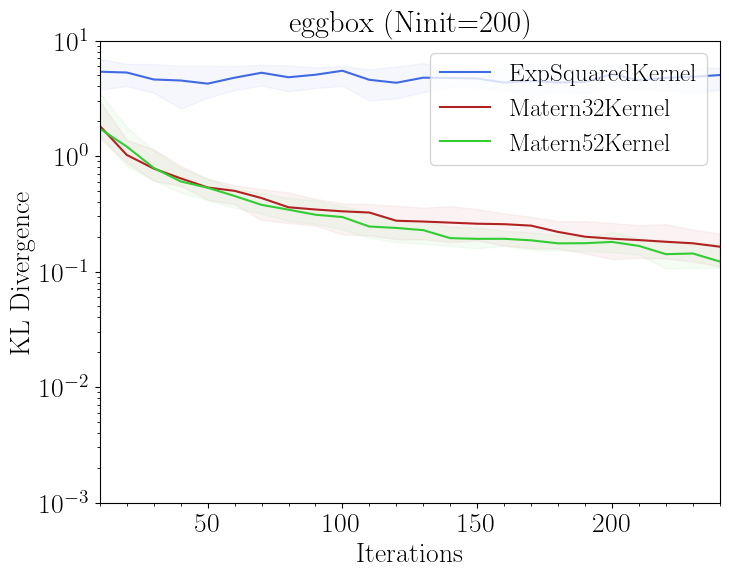

In [ ]:
colors = ["royalblue", "firebrick", "limegreen"]

for base_dir in base_dirs:
    
    ninit = base_dir.split("_mcmc")[0].split("init")[1]
    for example in examples:
        
        plt.figure(figsize=(8, 6))

        for ii, kernel in enumerate(kernels):
            
            key = f"{base_dir}/{example}/{kernel}"
            if key not in kl_results:
                print(f"Skipping {key} as no results found")
                continue
            
            kl_avg, kl_std, kl_25, kl_50, kl_75 = kl_results[key].T
            
            # plt.plot(iterations, kl_avg, label=f"{kernel}", color=colors[ii])
            # plt.fill_between(iterations, kl_avg - kl_std, kl_avg + kl_std, alpha=0.1, color=colors[ii])
            plt.plot(iterations, kl_50, label=f"{kernel}", color=colors[ii])
            plt.fill_between(iterations, kl_25, kl_75, alpha=0.05, color=colors[ii])
            plt.axhline(0, color="black", linestyle="--", linewidth=1)
            
        plt.legend(loc="upper right", fontsize=18)
        plt.xlabel("Iterations", fontsize=20)
        plt.ylabel("KL Divergence", fontsize=20)
        plt.xlim(iterations[0], iterations[-1])
        plt.yscale("log")
        plt.ylim(1e-3, 1e1)
        
        # Set custom y-axis tick labels
        plt.yticks([1e-3, 1e-2, 1e-1, 1e0, 1e1], ['$10^{-3}$', '$10^{-2}$', '$10^{-1}$', '$10^{0}$', '$10^{1}$'])
        
        plt.minorticks_on()
        plt.title(f"{example} (Ninit={ninit})", fontsize=22)
        # plt.savefig(f"plots/scaling_2d/kl_results_{base_dir}_{example}.png", bbox_inches="tight", dpi=300)
        plt.show()
        plt.close()

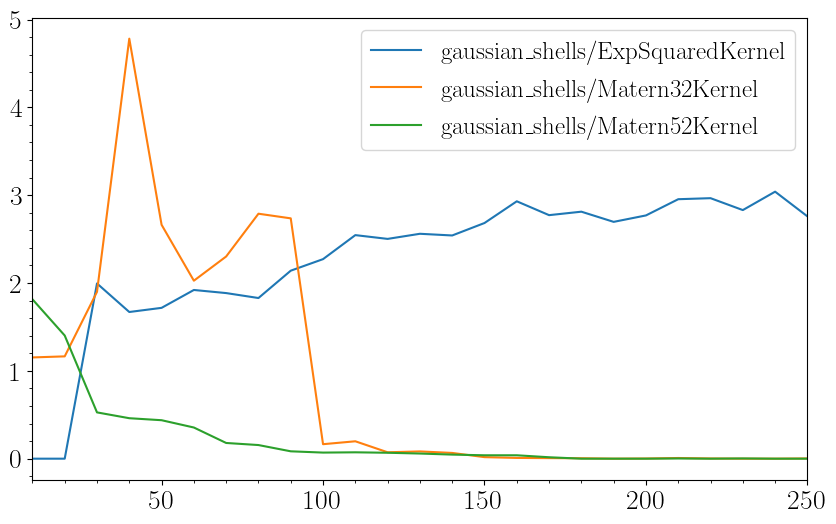

In [ ]:
plt.figure(figsize=(10, 6))
for key in kl_results.keys():
    plt.plot(iterations, kl_results[key], label=key.split("/")[-1])
plt.legend(loc='upper right', fontsize=18)
plt.xlim(iterations[0], iterations[-1])
plt.minorticks_on()
plt.show()